# Reading Phishing Mails From MailBox Files and Cleaning Unwanted Syntax

In [1]:
from bs4 import BeautifulSoup
from sklearn.metrics import classification_report
import pandas as pd
import email
import re, string, unicodedata
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_colwidth = 8000
import jpype as jp
from sklearn.ensemble import AdaBoostClassifier
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\
import seaborn as sns
import matplotlib.pyplot as graph
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Relative path to Zemberek .jar
ZEMBEREK_PATH = 'zemberek-full.jar'

# Start the JVM
jp.startJVM(jp.getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))
# Import required Java classes
TurkishMorphology = jp.JClass('zemberek.morphology.TurkishMorphology')
Paths = jp.JClass('java.nio.file.Paths')

# Instantiating the morphology class with the default RootLexicon
morphology = TurkishMorphology.createWithDefaults()



In [2]:
emails_df_ODTU_Oltalama = pd.read_csv('ODTU_Turkce_Oltalama.csv')
emails_df_ODTU_Oltalama['Body'].replace('\n', ' ',regex=True, inplace=True)
#emails_df_ODTU_Oltalama['email_body'].replace('\w\S*@.*\w', '',regex=True, inplace=True)
emails_df_ODTU_Oltalama['Body'].replace('https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)', '',regex=True, inplace=True)
emails_df_ODTU_Oltalama['Body'].replace('(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '',regex=True, inplace=True)
emails_df_ODTU_Oltalama['Body'].replace('=', '',regex=True, inplace=True)
emails_df_ODTU_Oltalama['Body'].replace('\t', '',regex=True, inplace=True)
emails_df_ODTU_Oltalama = emails_df_ODTU_Oltalama.drop_duplicates(subset='Body', keep='first', inplace=False)
emails_df_ODTU_Oltalama['Body'].replace('\t', '',regex=True, inplace=True)
emails_df_ODTU_Oltalama['Body'].replace('|', '',regex=True, inplace=True)
emails_df_ODTU_Oltalama['Body'].replace('&nbsp', '',regex=True, inplace=True)
emails_df_ODTU_Oltalama['Body'].replace('<[^>]*>', '',regex=True, inplace=True)
emails_df_ODTU_Oltalama['Body'].replace('-|[|]|<|>|_', '',regex=True, inplace=True)
#emails_df_ODTU_Oltalama['Body'].replace('[^A-Za-z]+', ' ',regex=True, inplace=True)
emails_df_ODTU_Oltalama = emails_df_ODTU_Oltalama.rename(index=str, columns={"Body": "Text", "Class": "Class"})


emails_df_ODTU_Oltalama['Class'] = 1
# Taking emails which which word counts are more than 5
emails_df_ODTU_Oltalama['word_count'] = emails_df_ODTU_Oltalama['Text'].apply(lambda x: len(str(x).split(" ")))
#cond = emails_df_ODTU['word_count'] > 5
#emails_df_ODTU = emails_df_ODTU[cond]
emails_df_ODTU_Oltalama = emails_df_ODTU_Oltalama.reset_index(drop=True)

In [3]:
#emails_df_ODTU_Oltalama

# Reading Ham Mails From CSV file and Cleaning

In [4]:
data2 = pd.read_csv('ODTU_Turkce_Ham.csv')

emails=[]
for item in data2['email_body']:
    emails_dict = {}
    full_email = email.message_from_string(item)
    body = full_email.get_payload()
    try:
        emails_dict["email_body"] = re.split(r"Kime:",body)[1]#"email body here"
    except IndexError:
        emails_dict["email_body"] = re.split(r"Kime:",body)[0]#"email body here"
    emails.append(emails_dict)

data2 = pd.DataFrame(emails)
data2['email_body'] = [BeautifulSoup(text).get_text() for text in data2['email_body']]
#data2 = data2.sample(frac=1).reset_index(drop = True)
data2['email_body'].replace('\n', ' ',regex=True, inplace=True)
data2['email_body'].replace('\w\S*@.*\w', '',regex=True, inplace=True)
data2['email_body'].replace('https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)', '',regex=True, inplace=True)
data2['email_body'].replace('(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '',regex=True, inplace=True)
data2['email_body'].replace('=', '',regex=True, inplace=True)
data2['email_body'].replace('\t', '',regex=True, inplace=True)
data2 = data2.drop_duplicates(subset='email_body', keep='first', inplace=False)
data2['email_body'].replace('\t', '',regex=True, inplace=True)
data2['email_body'].replace('|', '',regex=True, inplace=True)
data2['email_body'].replace('&nbsp', '',regex=True, inplace=True)
data2['email_body'].replace('<[^>]*>', '',regex=True, inplace=True)
data2['email_body'].replace('-|[|]|<|>|_', '',regex=True, inplace=True)
#data2['email_body'].replace('[^A-Za-z]+', ' ',regex=True, inplace=True)
data2 = data2.rename(index=str, columns={"email_body": "Text", "Class": "Class"})


data2['Class'] = 0
# Taking emails which which word counts are more than 3
data2['word_count'] = data2['Text'].apply(lambda x: len(str(x).split(" ")))
#cond = data2['word_count'] > 1
#data2 = data2[cond]
data2 = data2.reset_index(drop=True)

# Merging Two DataSet

In [5]:
calisma = pd.concat([emails_df_ODTU_Oltalama ,data2])
#[10:240]

In [6]:
calisma = calisma.reset_index(drop=True)

In [7]:
#cleaning all text from Numbers but holding (.)
calisma['Text'].replace('[^A-Za-zıiöüşçğİIÖÜŞÇĞ.]+', ' ',regex=True, inplace=True)

In [8]:
stop = stopwords.words('turkish')

In [9]:
calisma['StopWords'] = calisma['Text'].apply(lambda x: " ".join(x for x in x.split() if x in stop))
calisma['StopWordsCounts'] = calisma['Text'].apply(lambda x: len([x for x in x.split() if x in stop]))

In [10]:
#Cleaning text from stop words and making them smaller
calisma['Text'] = calisma['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
calisma['Text'] = calisma['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Most Frequent Phishing Mail Words
## Belki stemming yada lemmitazingten sonra yapılır.

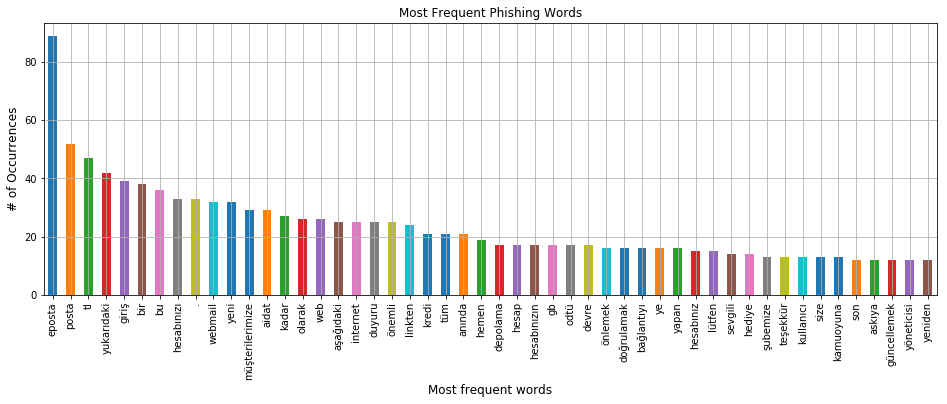

In [11]:
phishing = calisma[calisma['Class'] == 1]
freg_phishing = pd.Series(' '.join(phishing['Text']).split()).value_counts()[0:50]
freg_phishing.plot(x='Most Frequent Phishing Words', y='occurences', kind='bar', legend=False, grid=True, figsize=(16, 5))
plt.title("Most Frequent Phishing Words")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Most frequent words', fontsize=12)
plt.show()

# Most Frequent Ham Mail Words

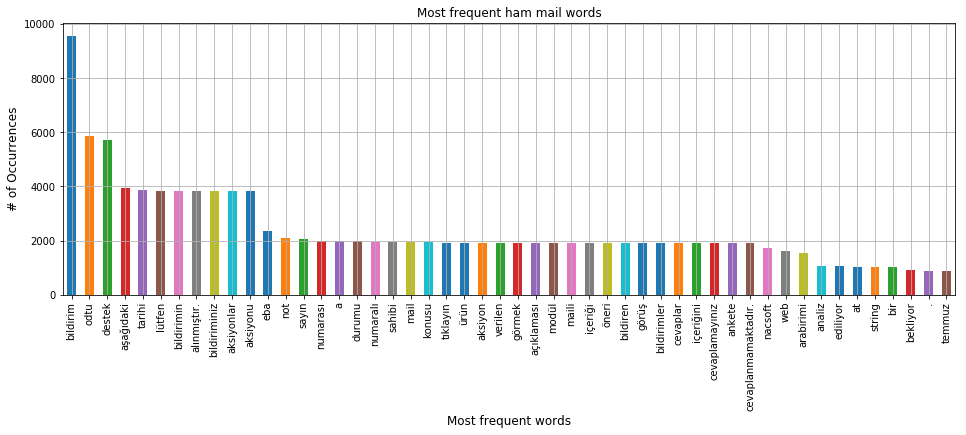

In [12]:
ham = calisma[calisma['Class'] == 0]
freg_ham = pd.Series(' '.join(ham['Text']).split()).value_counts()[0:50]
freg_ham.plot(x='Most frequent ham mail words', y='occurences', kind='bar', legend=False, grid=True, figsize=(16, 5))
plt.title("Most frequent ham mail words")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Most frequent words', fontsize=12)
plt.show()

# Dataset Most Frequent Words

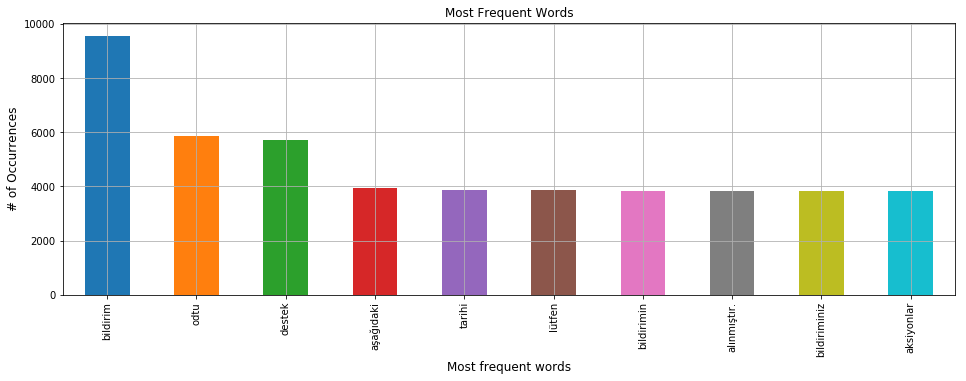

In [13]:
freq = pd.Series(' '.join(calisma['Text']).split()).value_counts()[:10]
freq.plot(x='Most frequent words', y='occurences', kind='bar', legend=False, grid=True, figsize=(16, 5))
plt.title("Most Frequent Words")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Most frequent words', fontsize=12)
plt.show()

In [14]:
freq = list(freq.index)
freq

['bildirim',
 'odtu',
 'destek',
 'aşağıdaki',
 'tarihi',
 'lütfen',
 'bildirimin',
 'alınmıştır.',
 'bildiriminiz',
 'aksiyonlar']

In [15]:
#removing 5 most frequent words 
calisma['Text'] = calisma['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [16]:
#removing english words
nltk.download('words')
words = set(nltk.corpus.words.words())
calisma['Text'] = calisma['Text'].apply(lambda x: ' '.join(w for w in nltk.wordpunct_tokenize(x) if w not in words))

[nltk_data] Error loading words: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1051)>


In [17]:
freq = pd.Series(' '.join(calisma['Text']).split()).value_counts()[-10:]
freq

ariza                1
ulaşırsanız          1
writes               1
nşası                1
seçiyor              1
aidatları            1
yaptırken            1
hayatdenizdegüzel    1
anket                1
güzeldir             1
dtype: int64

In [18]:
#removing 
freq = list(freq.index)
calisma['Text'] = calisma['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

# Dataset Class

3645

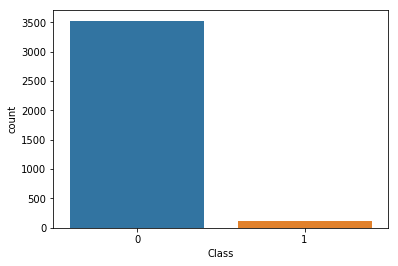

In [19]:
#1 for Phishing
import seaborn as sns
sns.countplot(x = 'Class', data = calisma)
len(calisma)

## Lemmatization

In [20]:
def lemma(text):
    toplam = ''
    cumle = nltk.sent_tokenize(text)
    for sentence in cumle:
        results = morphology.analyzeAndDisambiguate(sentence).bestAnalysis()
        for word in results:
            #if str(word.getLemmas()[0]) == 'UNK':
            #    cumle += word + ' '
            #else:        
            toplam += word.getLemmas()[0] + ' '
    return toplam

newStopWords = ['UNK', '.', '...']
    
calisma['Text'] = calisma['Text'].apply(lemma)
calisma['Text'] = calisma['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in newStopWords))


In [21]:
#tez icerisinde kullanilmak uzere ornek olarak yapilmistir.
text = 'Kamuoyuna Duyuru, Kredi kartı kullanan tüm vatandaşlarımızın aidat iadesi 4395 sayılı kanun gereğince 1000 TL ye kadar anında iadesi yapılmaktadır. Kredi kartlarınızın aidat iadesini almak için tıklayınız.'
sonuc = nltk.sent_tokenize(lemma(text))
cikti = ''
newStopWords = ['UNK', '.', '...']
for i in sonuc: 
    if i == 'UNK':
        a = 'geldi'
    else:
        cikti += i + ' ' 

print(cikti)

kamuoyu duyuru , kredi kart kullan tüm vatandaş aidat iade 4395 sayılı kanun gereğince 1000 tl ye kadar an iade yap . kredi kart aidat iade al için tıkla . 


# Splitting Dataset 

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(calisma['Text'], calisma['Class'], random_state=1, test_size=0.33)

# Tf-idf

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=950, lowercase=True, analyzer='word',ngram_range=(1,1))
train_vect_tfidf = tfidf.fit_transform(X_train)
train_data_features_tfidf = train_vect_tfidf.toarray()
test_data_features_tfidf = tfidf.transform(X_test)
test_data_features_tfidf = test_data_features_tfidf.toarray()

# Bag of Words

In [24]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(max_features=950,analyzer="word",
                             tokenizer=None,
                             preprocessor=None,
                             stop_words=None)

train_vect_cv = cv.fit_transform(X_train)


train_data_features_cv = train_vect_cv.toarray()
test_data_features_cv = cv.transform(X_test)
test_data_features_cv = test_data_features_cv.toarray()

In [25]:

df = pd.DataFrame(train_vect_tfidf.toarray(), columns = tfidf.get_feature_names())
df.iloc[:10,20:30]
#df

,aksiyon,aktar,aktarım,aktif,akıl,akşam,al,alan,ales,ali
0,0.195335,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.285799,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.312168,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.253562,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.262296,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5,0.193843,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6,0.273603,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
7,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8,0.190830,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.320962,0.0,0.0,0.0


In [26]:

df = pd.DataFrame(train_vect_cv.toarray(), columns = cv.get_feature_names())
df.iloc[:10,20:30]
#df

,aksiyon,aktar,aktarım,aktif,akıl,akşam,al,alan,ales,ali
0,3,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0
5,3,0,0,0,0,0,0,0,0,0
6,3,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,3,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,2,0,0,0


In [27]:
len(list(cv.vocabulary_.keys())[:])
#list(cv.vocabulary_.keys())[:10]

950

In [28]:
feature_names = tfidf.get_feature_names()
feature_names

['abdullah',
 'acaba',
 'acil',
 'acilen',
 'ad',
 'aday',
 'adi',
 'admin',
 'adnan',
 'adres',
 'adım',
 'ahmet',
 'aidat',
 'aile',
 'ak',
 'akademik',
 'akademisyen',
 'akaryakıt',
 'akbank',
 'akis',
 'aksiyon',
 'aktar',
 'aktarım',
 'aktif',
 'akıl',
 'akşam',
 'al',
 'alan',
 'ales',
 'ali',
 'almanya',
 'alt',
 'altunışık',
 'alım',
 'alın',
 'alıntı',
 'alışveriş',
 'amaç',
 'an',
 'analiz',
 'ancak',
 'ankara',
 'anket',
 'anla',
 'anlam',
 'anlaş',
 'anma',
 'anne',
 'antalya',
 'antet',
 'ara',
 'arabirim',
 'aralık',
 'arayüz',
 'araç',
 'araştır',
 'arkadaş',
 'art',
 'artık',
 'arz',
 'arıza',
 'aspendos',
 'at',
 'ata',
 'atakan',
 'atar',
 'atatürk',
 'avrupa',
 'axess',
 'ay',
 'ayarla',
 'ayni',
 'aynı',
 'ayrica',
 'ayrı',
 'ayrıca',
 'ayrıntı',
 'ayır',
 'aç',
 'açı',
 'açık',
 'açıkla',
 'ağustos',
 'aş',
 'aşama',
 'aşağı',
 'baba',
 'bahset',
 'bak',
 'baki',
 'bakım',
 'balaban',
 'balkan',
 'banka',
 'barnes',
 'bas',
 'basit',
 'bayram',
 'baz',
 'bazı',
 'b

In [29]:
doc = 0
feature_index = train_vect_tfidf[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [train_vect_tfidf[doc, x] for x in feature_index])
feature_index

array([662, 594, 502, 306, 333, 736, 268, 239, 325, 923, 559,  51,  52,
       651,  81,  20, 596, 120, 223, 459, 739, 511, 113, 442, 336, 533,
       601, 862, 602, 570, 128, 197,  42, 806, 166, 347, 904, 532, 167,
       122, 340, 783], dtype=int32)

In [30]:
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)

sayın 0.06335191136396047
numara 0.12838330178117976
konu 0.063919772173664
gel 0.22837759124523704
gmail 0.42169893196070996
takip 0.31667109266646665
et 0.1974961279789449
ek 0.24027346049689716
gibi 0.17720182550179422
ürün 0.06489512263269692
modül 0.06504973250482445
arabirim 0.07336951817748766
aralık 0.14787485793094343
sahip 0.06428269685903885
açıkla 0.06495689358536386
aksiyon 0.19533524167845204
ocak 0.1442233474163915
bil 0.06338159502068243
durum 0.12820163086647685
kapa 0.10075418097091854
talep 0.09708675153001627
kullan 0.08833427137208277
bekle 0.08855908639360294
içerik 0.12997563104295232
gönder 0.1398292395515581
mail 0.23936885779984352
ol 0.1669793318941136
yönlen 0.23445165878859406
oluş 0.1421849832849547
müdahale 0.25155370288119633
bir 0.10345916571230823
değil 0.18237097610917583
anket 0.06511174722615068
ver 0.06244266894979399
cevap 0.06461834899462883
görüş 0.06483344865173808
öneri 0.06501876181516178
mai 0.06514279133507739
cevapla 0.13034771998901595
bi

hepsi           28
ferdi           28
güven           28
şua             28
akaryakıt       28
tatil           28
sorgula         28
sonuç           28
geç             28
anla            27
dön             27
internet        27
telefon         27
garanti         27
geçersiz        27
eksik           27
tara            27
böyle           27
konser          27
mutlu           26
ev              26
sınır           26
sıkıntı         26
doç             26
boyut           26
ifade           26
bütçe           25
konuş           25
sor             25
faks            25
                ..
üniversitesi    21
koordinatör     21
birbiri         21
belli           21
paraf           21
tespit          21
yönlen          21
aile            21
kullanım        21
imkan           21
gelecek         21
rağmen          21
tanım           21
aktif           20
herkes          20
listele         20
birden          20
sık             20
esna            20
ayrı            20
nazan           20
şimdi       

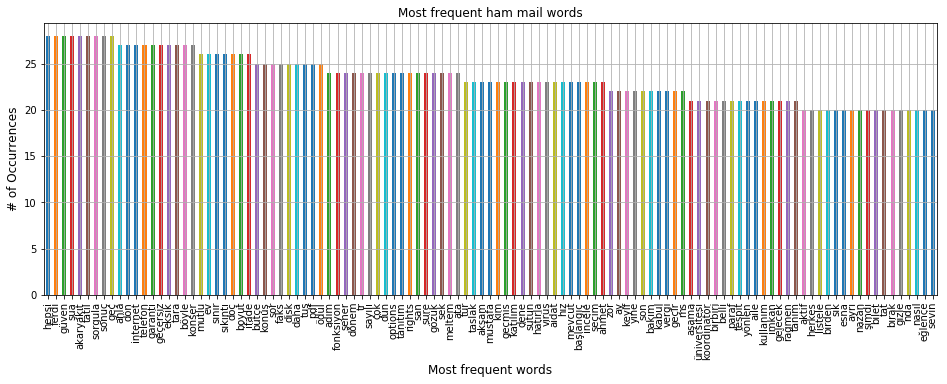

In [31]:

freg_ham = pd.Series(' '.join(X_train).split()).value_counts()[400:511]
freg_ham.plot(x='Most frequent ham mail words', y='occurences', kind='bar', legend=False, grid=True, figsize=(16, 5))
plt.title("Most frequent ham mail words")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Most frequent words', fontsize=12)
#plt.show()
freg_ham

In [32]:
len(list(cv.vocabulary_.keys())[:])

950

In [33]:
np.bincount(y_train)

array([2363,   79])

In [34]:
np.bincount(y_test)

array([1163,   40])

## Random Under Sampling

In [35]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_rusampled_tfidf, y_rusampled_tfidf = rus.fit_resample(train_data_features_tfidf, y_train)
X_rusampled_cv, y_rusampled_cv = rus.fit_resample(train_data_features_cv, y_train)

In [36]:
np.bincount(y_rusampled_cv)

array([79, 79])

## Random Over Sampling

In [37]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_rosampled_tfidf, y_rosampled_tfidf = ros.fit_resample(train_data_features_tfidf, y_train)
X_rosampled_cv, y_rosampled_cv = ros.fit_resample(train_data_features_cv, y_train)

In [38]:
np.bincount(y_rosampled_tfidf)

array([2363, 2363])

## SMOTE

In [39]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_smsampled_tfidf, y_smsampled_tfidf = sm.fit_resample(train_data_features_tfidf, y_train)
X_smsampled_cv, y_smsampled_cv = sm.fit_resample(train_data_features_cv, y_train)

In [40]:
np.bincount(y_smsampled_tfidf)

array([2363, 2363])

# Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

# training Random Forest with based tfidf
forest_tfidf = RandomForestClassifier(n_estimators=150)
_ = forest_tfidf.fit(train_data_features_tfidf, y_train)

In [42]:
# training Random Forest with based cv
forest_cv = RandomForestClassifier(n_estimators=35)
_ = forest_cv.fit(train_data_features_cv, y_train)

### Random Forest with Under Sampling

In [43]:
forest_tfidf_rus = RandomForestClassifier(n_estimators=30)
_ = forest_tfidf_rus.fit(X_rusampled_tfidf, y_rusampled_tfidf)

In [44]:
forest_cv_rus = RandomForestClassifier(n_estimators=30)
_ = forest_cv_rus.fit(X_rusampled_cv, y_rusampled_cv)

### Random Forest with Over Sampling

In [45]:
forest_tfidf_ros = RandomForestClassifier(n_estimators=10)
_ = forest_tfidf_ros.fit(X_rosampled_tfidf, y_rosampled_tfidf)

In [46]:
forest_cv_ros = RandomForestClassifier(n_estimators=30)
_ = forest_cv_ros.fit(X_rosampled_cv, y_rosampled_cv)

### Random Forest with SMOTE

In [47]:
forest_tfidf_sm = RandomForestClassifier(n_estimators=100)
_ = forest_tfidf_sm.fit(X_smsampled_tfidf, y_smsampled_tfidf)

In [48]:
forest_cv_sm = RandomForestClassifier(n_estimators=50)
_ = forest_cv_sm.fit(X_smsampled_cv, y_smsampled_cv)

### Random Forest Results

In [49]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score

forest_tfidf_base_pred = forest_tfidf.predict(test_data_features_tfidf)
forest_tfidf_rus_pred = forest_tfidf_rus.predict(test_data_features_tfidf)
forest_tfidf_ros_pred = forest_tfidf_ros.predict(test_data_features_tfidf)
forest_tfidf_sm_pred = forest_tfidf_sm.predict(test_data_features_tfidf)

forest_cv_base_pred = forest_cv.predict(test_data_features_cv)
forest_cv_rus_pred = forest_cv_rus.predict(test_data_features_cv)
forest_cv_ros_pred = forest_cv_ros.predict(test_data_features_cv)
forest_cv_sm_pred = forest_cv_sm.predict(test_data_features_cv)

In [50]:
#from sklearn.metrics import classification_report
#print('------------------RANDOM FOREST-TDIDF-----------------------\n')
#print(classification_report(y_test, forest_tfidf_base_pred))
#print('------------------Under Sampling----------------------------\n')
#print(classification_report(y_test, forest_tfidf_rus_pred))
#print('------------------Over Sampling-----------------------------\n')
#print(classification_report(y_test, forest_tfidf_ros_pred))
#print('------------------Smote-------------------------------------\n')
#print(classification_report(y_test, forest_tfidf_sm_pred))

In [51]:
#print('------------------RANDOM FOREST-CV--------------------------\n')
#print(classification_report(y_test, forest_cv_base_pred))
#print('------------------Under Sampling----------------------------\n')
#print(classification_report(y_test, forest_cv_rus_pred))
#print('------------------Over Sampling-----------------------------\n')
#print(classification_report(y_test, forest_cv_ros_pred))
#print('------------------Smote-------------------------------------\n')
#print(classification_report(y_test, forest_cv_sm_pred))

In [52]:
#precision_score(y_test, forest_tfidf_base_pred)
forest_tfidf_base_preci = precision_score(y_test, forest_tfidf_base_pred)
forest_tfidf_rus_preci = precision_score(y_test, forest_tfidf_rus_pred)
forest_tfidf_ros_preci = precision_score(y_test, forest_tfidf_ros_pred)
forest_tfidf_sm_preci = precision_score(y_test, forest_tfidf_sm_pred)

forest_cv_base_preci = precision_score(y_test, forest_cv_base_pred)
forest_cv_rus_preci = precision_score(y_test, forest_cv_rus_pred)
forest_cv_ros_preci = precision_score(y_test, forest_cv_ros_pred)
forest_cv_sm_preci = precision_score(y_test, forest_cv_sm_pred)

forest_tfidf_base_rec = recall_score(y_test, forest_tfidf_base_pred)
forest_tfidf_rus_rec = recall_score(y_test, forest_tfidf_rus_pred)
forest_tfidf_ros_rec = recall_score(y_test, forest_tfidf_ros_pred)
forest_tfidf_sm_rec = recall_score(y_test, forest_tfidf_sm_pred)

forest_cv_base_rec = recall_score(y_test, forest_cv_base_pred)
forest_cv_rus_rec = recall_score(y_test, forest_cv_rus_pred)
forest_cv_ros_rec = recall_score(y_test, forest_cv_ros_pred)
forest_cv_sm_rec = recall_score(y_test, forest_cv_sm_pred)

forest_tfidf_base_f1 = f1_score(y_test, forest_tfidf_base_pred)
forest_tfidf_rus_f1 = f1_score(y_test, forest_tfidf_rus_pred)
forest_tfidf_ros_f1 = f1_score(y_test, forest_tfidf_ros_pred)
forest_tfidf_sm_f1 = f1_score(y_test, forest_tfidf_sm_pred)

forest_cv_base_f1 = f1_score(y_test, forest_cv_base_pred)
forest_cv_rus_f1 = f1_score(y_test, forest_cv_rus_pred)
forest_cv_ros_f1 = f1_score(y_test, forest_cv_ros_pred)
forest_cv_sm_f1 = f1_score(y_test, forest_cv_sm_pred)

forest_tfidf_base_auc = accuracy_score(y_test, forest_tfidf_base_pred)
forest_tfidf_rus_auc = accuracy_score(y_test, forest_tfidf_rus_pred)
forest_tfidf_ros_auc = accuracy_score(y_test, forest_tfidf_ros_pred)
forest_tfidf_sm_auc = accuracy_score(y_test, forest_tfidf_sm_pred)

forest_cv_base_auc = accuracy_score(y_test, forest_cv_base_pred)
forest_cv_rus_auc = accuracy_score(y_test, forest_cv_rus_pred)
forest_cv_ros_auc = accuracy_score(y_test, forest_cv_ros_pred)
forest_cv_sm_auc = accuracy_score(y_test, forest_cv_sm_pred)

# Support Vector Machine

In [53]:
from sklearn.svm import SVC

svc_tfidf = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


_ = svc_tfidf.fit(train_data_features_tfidf, y_train)

In [54]:
svc_cv = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
_ = svc_cv.fit(train_data_features_cv, y_train)

### Support Vector Machine with Under Sampling

In [55]:
svc_tfidf_rus =SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

_ = svc_tfidf_rus.fit(X_rusampled_tfidf, y_rusampled_tfidf)

In [56]:
svc_cv_rus = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
_ = svc_cv_rus.fit(X_rusampled_cv, y_rusampled_cv)

### Support Vector Machine with Over Sampling

In [57]:
svc_tfidf_ros = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
_ = svc_tfidf_ros.fit(X_rosampled_tfidf, y_rosampled_tfidf)

In [58]:
svc_cv_ros = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
_ = svc_cv_ros.fit(X_rosampled_cv, y_rosampled_cv)

### Support Vector Machine with Smote

In [59]:
svc_tfidf_sm =SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
_ = svc_tfidf_sm.fit(X_smsampled_tfidf, y_smsampled_tfidf)

In [60]:
svc_cv_sm = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

_ = svc_cv_sm.fit(X_smsampled_cv, y_smsampled_cv)

### Support Vector Machine Results

In [61]:
svc_tfidf_base_pred = svc_tfidf.predict(test_data_features_tfidf)
svc_tfidf_rus_pred = svc_tfidf_rus.predict(test_data_features_tfidf)
svc_tfidf_ros_pred = svc_tfidf_ros.predict(test_data_features_tfidf)
svc_tfidf_sm_pred = svc_tfidf_sm.predict(test_data_features_tfidf)

svc_cv_base_pred = svc_cv.predict(test_data_features_cv)
svc_cv_rus_pred = svc_cv_rus.predict(test_data_features_cv)
svc_cv_ros_pred = svc_cv_ros.predict(test_data_features_cv)
svc_cv_sm_pred = svc_cv_sm.predict(test_data_features_cv)

In [62]:
svc_tfidf_base_preci = precision_score(y_test, svc_tfidf_base_pred)
svc_tfidf_rus_preci = precision_score(y_test, svc_tfidf_rus_pred)
svc_tfidf_ros_preci = precision_score(y_test, svc_tfidf_ros_pred)
svc_tfidf_sm_preci = precision_score(y_test, svc_tfidf_sm_pred)

svc_cv_base_preci = precision_score(y_test, svc_cv_base_pred)
svc_cv_rus_preci = precision_score(y_test, svc_cv_rus_pred)
svc_cv_ros_preci = precision_score(y_test, svc_cv_ros_pred)
svc_cv_sm_preci = precision_score(y_test, svc_cv_sm_pred)

svc_tfidf_base_rec = recall_score(y_test, svc_tfidf_base_pred)
svc_tfidf_rus_rec = recall_score(y_test, svc_tfidf_rus_pred)
svc_tfidf_ros_rec = recall_score(y_test, svc_tfidf_ros_pred)
svc_tfidf_sm_rec = recall_score(y_test, svc_tfidf_sm_pred)

svc_cv_base_rec = recall_score(y_test, svc_cv_base_pred)
svc_cv_rus_rec = recall_score(y_test, svc_cv_rus_pred)
svc_cv_ros_rec = recall_score(y_test, svc_cv_ros_pred)
svc_cv_sm_rec = recall_score(y_test, svc_cv_sm_pred)

svc_tfidf_base_f1 = f1_score(y_test, svc_tfidf_base_pred)
svc_tfidf_rus_f1 = f1_score(y_test, svc_tfidf_rus_pred)
svc_tfidf_ros_f1 = f1_score(y_test, svc_tfidf_ros_pred)
svc_tfidf_sm_f1 = f1_score(y_test, svc_tfidf_sm_pred)

svc_cv_base_f1 = f1_score(y_test, svc_cv_base_pred)
svc_cv_rus_f1 = f1_score(y_test, svc_cv_rus_pred)
svc_cv_ros_f1 = f1_score(y_test, svc_cv_ros_pred)
svc_cv_sm_f1 = f1_score(y_test, svc_cv_sm_pred)

svc_tfidf_base_auc = accuracy_score(y_test, svc_tfidf_base_pred)
svc_tfidf_rus_auc = accuracy_score(y_test, svc_tfidf_rus_pred)
svc_tfidf_ros_auc = accuracy_score(y_test, svc_tfidf_ros_pred)
svc_tfidf_sm_auc = accuracy_score(y_test, svc_tfidf_sm_pred)

svc_cv_base_auc = accuracy_score(y_test, svc_cv_base_pred)
svc_cv_rus_auc = accuracy_score(y_test, svc_cv_rus_pred)
svc_cv_ros_auc = accuracy_score(y_test, svc_cv_ros_pred)
svc_cv_sm_auc = accuracy_score(y_test, svc_cv_sm_pred)

# AdaBoost

In [63]:
ada_tfidf = AdaBoostClassifier(n_estimators=100)
_ = ada_tfidf.fit(train_data_features_tfidf, y_train)

In [64]:
ada_cv = AdaBoostClassifier(n_estimators=250)
_ = ada_cv.fit(train_data_features_cv, y_train)

### AdaBoost with Under Sampling

In [65]:
ada_tfidf_rus = AdaBoostClassifier(n_estimators=600)
_ = ada_tfidf_rus.fit(X_rusampled_tfidf, y_rusampled_tfidf)

In [66]:
ada_cv_rus = AdaBoostClassifier(n_estimators=50)
_ = ada_cv_rus.fit(X_rusampled_cv, y_rusampled_cv)

### AdaBoost with Over Sampling

In [67]:
ada_tfidf_ros = AdaBoostClassifier(n_estimators=300)
_ = ada_tfidf_ros.fit(X_rosampled_tfidf, y_rosampled_tfidf)

In [68]:
ada_cv_ros = AdaBoostClassifier(n_estimators=300)
_ = ada_cv_ros.fit(X_rosampled_cv, y_rosampled_cv)

### AdaBoost with Smote

In [69]:
ada_tfidf_sm = AdaBoostClassifier(n_estimators=400)
_ = ada_tfidf_sm.fit(X_smsampled_tfidf, y_smsampled_tfidf)

In [70]:
ada_cv_sm = AdaBoostClassifier(n_estimators=500)
_ = ada_cv_sm.fit(X_smsampled_cv, y_smsampled_cv)

### AdaBoost Results

In [71]:
ada_tfidf_base_pred = ada_tfidf.predict(test_data_features_tfidf)
ada_tfidf_rus_pred = ada_tfidf_rus.predict(test_data_features_tfidf)
ada_tfidf_ros_pred = ada_tfidf_ros.predict(test_data_features_tfidf)
ada_tfidf_sm_pred = ada_tfidf_sm.predict(test_data_features_tfidf)

ada_cv_base_pred = ada_cv.predict(test_data_features_cv)
ada_cv_rus_pred = ada_cv_rus.predict(test_data_features_cv)
ada_cv_ros_pred = ada_cv_ros.predict(test_data_features_cv)
ada_cv_sm_pred = ada_cv_sm.predict(test_data_features_cv)

In [72]:
ada_tfidf_base_preci = precision_score(y_test, ada_tfidf_base_pred)
ada_tfidf_rus_preci = precision_score(y_test, ada_tfidf_rus_pred)
ada_tfidf_ros_preci = precision_score(y_test, ada_tfidf_ros_pred)
ada_tfidf_sm_preci = precision_score(y_test, ada_tfidf_sm_pred)

ada_cv_base_preci = precision_score(y_test, ada_cv_base_pred)
ada_cv_rus_preci = precision_score(y_test, ada_cv_rus_pred)
ada_cv_ros_preci = precision_score(y_test, ada_cv_ros_pred)
ada_cv_sm_preci = precision_score(y_test, ada_cv_sm_pred)

ada_tfidf_base_rec = recall_score(y_test, ada_tfidf_base_pred)
ada_tfidf_rus_rec = recall_score(y_test, ada_tfidf_rus_pred)
ada_tfidf_ros_rec = recall_score(y_test, ada_tfidf_ros_pred)
ada_tfidf_sm_rec = recall_score(y_test, ada_tfidf_sm_pred)

ada_cv_base_rec = recall_score(y_test, ada_cv_base_pred)
ada_cv_rus_rec = recall_score(y_test, ada_cv_rus_pred)
ada_cv_ros_rec = recall_score(y_test, ada_cv_ros_pred)
ada_cv_sm_rec = recall_score(y_test, ada_cv_sm_pred)

ada_tfidf_base_f1 = f1_score(y_test, ada_tfidf_base_pred)
ada_tfidf_rus_f1 = f1_score(y_test, ada_tfidf_rus_pred)
ada_tfidf_ros_f1 = f1_score(y_test, ada_tfidf_ros_pred)
ada_tfidf_sm_f1 = f1_score(y_test, ada_tfidf_sm_pred)

ada_cv_base_f1 = f1_score(y_test, ada_cv_base_pred)
ada_cv_rus_f1 = f1_score(y_test, ada_cv_rus_pred)
ada_cv_ros_f1 = f1_score(y_test, ada_cv_ros_pred)
ada_cv_sm_f1 = f1_score(y_test, ada_cv_sm_pred)

ada_tfidf_base_auc = accuracy_score(y_test, ada_tfidf_base_pred)
ada_tfidf_rus_auc = accuracy_score(y_test, ada_tfidf_rus_pred)
ada_tfidf_ros_auc = accuracy_score(y_test, ada_tfidf_ros_pred)
ada_tfidf_sm_auc = accuracy_score(y_test, ada_tfidf_sm_pred)

ada_cv_base_auc = accuracy_score(y_test, ada_cv_base_pred)
ada_cv_rus_auc = accuracy_score(y_test, ada_cv_rus_pred)
ada_cv_ros_auc = accuracy_score(y_test, ada_cv_ros_pred)
ada_cv_sm_auc = accuracy_score(y_test, ada_cv_sm_pred)

# Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression

log_tfidf = LogisticRegression(C=500)
_ = log_tfidf.fit(train_data_features_tfidf, y_train)

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [74]:
log_cv = LogisticRegression(C=20)
_ = log_cv.fit(train_data_features_cv, y_train)

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Logistic Regression with Under Sampling

In [75]:
log_tfidf_rus = LogisticRegression(C=1)
_ = log_tfidf_rus.fit(X_rusampled_tfidf, y_rusampled_tfidf)

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [76]:
log_cv_rus = LogisticRegression(C=1)
_ = log_cv_rus.fit(X_rusampled_cv, y_rusampled_cv)

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Logistic Regression with Over Sampling

In [77]:
log_tfidf_ros = LogisticRegression(C=5)
_ = log_tfidf_ros.fit(X_rosampled_tfidf, y_rosampled_tfidf)

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [78]:
log_cv_ros = LogisticRegression(C=1)
_ = log_cv_ros.fit(X_rosampled_cv, y_rosampled_cv)

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Logistic Regresion Smote

In [79]:
log_tfidf_sm = LogisticRegression(C=5)
_ = log_tfidf_sm.fit(X_smsampled_tfidf, y_smsampled_tfidf)

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
log_cv_sm = LogisticRegression(C=500)
_ = log_cv_sm.fit(X_smsampled_cv, y_smsampled_cv)

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Logistic Regression Results

In [81]:
log_tfidf_base_pred = log_tfidf.predict(test_data_features_tfidf)
log_tfidf_rus_pred = log_tfidf_rus.predict(test_data_features_tfidf)
log_tfidf_ros_pred = log_tfidf_ros.predict(test_data_features_tfidf)
log_tfidf_sm_pred = log_tfidf_sm.predict(test_data_features_tfidf)

log_cv_base_pred = log_cv.predict(test_data_features_cv)
log_cv_rus_pred = log_cv_rus.predict(test_data_features_cv)
log_cv_ros_pred = log_cv_ros.predict(test_data_features_cv)
log_cv_sm_pred = log_cv_sm.predict(test_data_features_cv)

In [82]:
log_tfidf_base_preci = precision_score(y_test, log_tfidf_base_pred)
log_tfidf_rus_preci = precision_score(y_test, log_tfidf_rus_pred)
log_tfidf_ros_preci = precision_score(y_test, log_tfidf_ros_pred)
log_tfidf_sm_preci = precision_score(y_test, log_tfidf_sm_pred)

log_cv_base_preci = precision_score(y_test, log_cv_base_pred)
log_cv_rus_preci = precision_score(y_test, log_cv_rus_pred)
log_cv_ros_preci = precision_score(y_test, log_cv_ros_pred)
log_cv_sm_preci = precision_score(y_test, log_cv_sm_pred)

log_tfidf_base_rec = recall_score(y_test, log_tfidf_base_pred)
log_tfidf_rus_rec = recall_score(y_test, log_tfidf_rus_pred)
log_tfidf_ros_rec = recall_score(y_test, log_tfidf_ros_pred)
log_tfidf_sm_rec = recall_score(y_test, log_tfidf_sm_pred)

log_cv_base_rec = recall_score(y_test, log_cv_base_pred)
log_cv_rus_rec = recall_score(y_test, log_cv_rus_pred)
log_cv_ros_rec = recall_score(y_test, log_cv_ros_pred)
log_cv_sm_rec = recall_score(y_test, log_cv_sm_pred)

log_tfidf_base_f1 = f1_score(y_test, log_tfidf_base_pred)
log_tfidf_rus_f1 = f1_score(y_test, log_tfidf_rus_pred)
log_tfidf_ros_f1 = f1_score(y_test, log_tfidf_ros_pred)
log_tfidf_sm_f1 = f1_score(y_test, log_tfidf_sm_pred)

log_cv_base_f1 = f1_score(y_test, log_cv_base_pred)
log_cv_rus_f1 = f1_score(y_test, log_cv_rus_pred)
log_cv_ros_f1 = f1_score(y_test, log_cv_ros_pred)
log_cv_sm_f1 = f1_score(y_test, log_cv_sm_pred)

log_tfidf_base_auc = accuracy_score(y_test, log_tfidf_base_pred)
log_tfidf_rus_auc = accuracy_score(y_test, log_tfidf_rus_pred)
log_tfidf_ros_auc = accuracy_score(y_test, log_tfidf_ros_pred)
log_tfidf_sm_auc = accuracy_score(y_test, log_tfidf_sm_pred)

log_cv_base_auc = accuracy_score(y_test, log_cv_base_pred)
log_cv_rus_auc = accuracy_score(y_test, log_cv_rus_pred)
log_cv_ros_auc = accuracy_score(y_test, log_cv_ros_pred)
log_cv_sm_auc = accuracy_score(y_test, log_cv_sm_pred)

# Accuracy Score

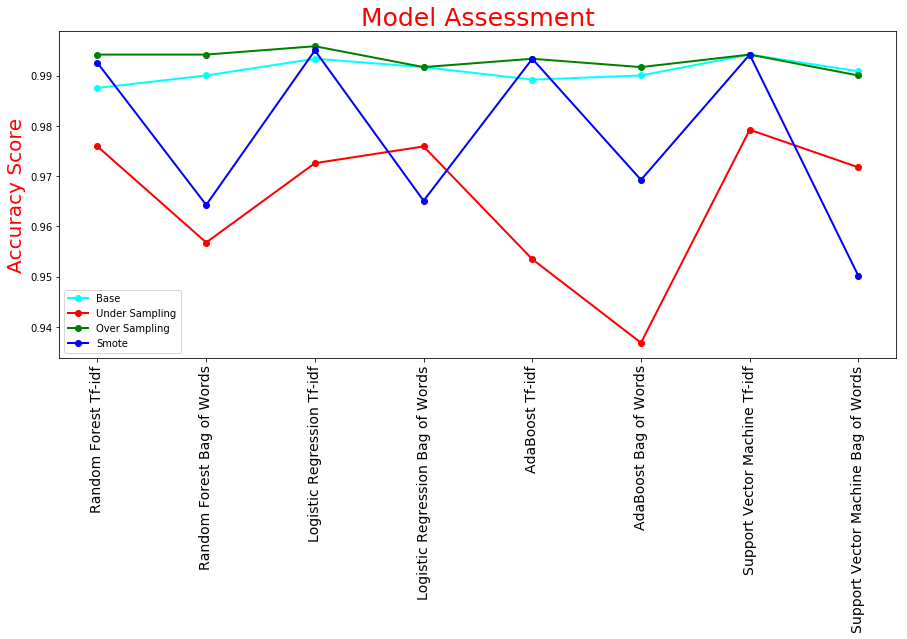

In [83]:
x = ['Random Forest Tf-idf', 'Random Forest Bag of Words', 'Logistic Regression Tf-idf', 'Logistic Regression Bag of Words', 'AdaBoost Tf-idf', 'AdaBoost Bag of Words', 'Support Vector Machine Tf-idf','Support Vector Machine Bag of Words']
y_base_auc = [forest_tfidf_base_auc, forest_cv_base_auc, log_tfidf_base_auc, log_cv_base_auc, ada_tfidf_base_auc, ada_cv_base_auc, svc_tfidf_base_auc, svc_cv_base_auc]
y_rus_auc = [forest_tfidf_rus_auc, forest_cv_rus_auc, log_tfidf_rus_auc, log_cv_rus_auc, ada_tfidf_rus_auc, ada_cv_rus_auc, svc_tfidf_rus_auc, svc_cv_rus_auc]
y_ros_auc = [forest_tfidf_ros_auc, forest_cv_ros_auc, log_tfidf_ros_auc, log_cv_ros_auc, ada_tfidf_ros_auc, ada_cv_ros_auc, svc_tfidf_ros_auc, svc_cv_ros_auc]
y_sm_auc = [forest_tfidf_sm_auc, forest_cv_sm_auc, log_tfidf_sm_auc, log_cv_sm_auc, ada_tfidf_sm_auc, ada_cv_sm_auc, svc_tfidf_sm_auc, svc_cv_sm_auc]

df=pd.DataFrame({'Models': x, 'Base': y_base_auc, 'Under Sampling': y_rus_auc, 'Over Sampling': y_ros_auc, 'Smote': y_sm_auc})

plt.figure(figsize=(15,6))
plt.plot( 'Models', 'Base', data=df, marker='o', markerfacecolor='cyan', color='cyan', linewidth=2)
plt.plot( 'Models', 'Under Sampling', data=df, marker='o',markerfacecolor='red', color='red', linewidth=2)
plt.plot( 'Models', 'Over Sampling', data=df, marker='o',markerfacecolor='green', color='green', linewidth=2)
plt.plot( 'Models', 'Smote', data=df, marker='o',markerfacecolor='blue', color='blue', linewidth=2,)
plt.ylabel('Accuracy Score',color = 'red',size = 20)
plt.title('Model Assessment', color = 'red', size = 25)
#plt.yticks(np.arange(0.7, 1, step=0.05))
plt.xticks(x, rotation=90, color = 'black',size = 14)
plt.legend(loc=3)
#plt.savefig('drive/sampled06.pdf', format='pdf', dpi=1000)


# Precision Score

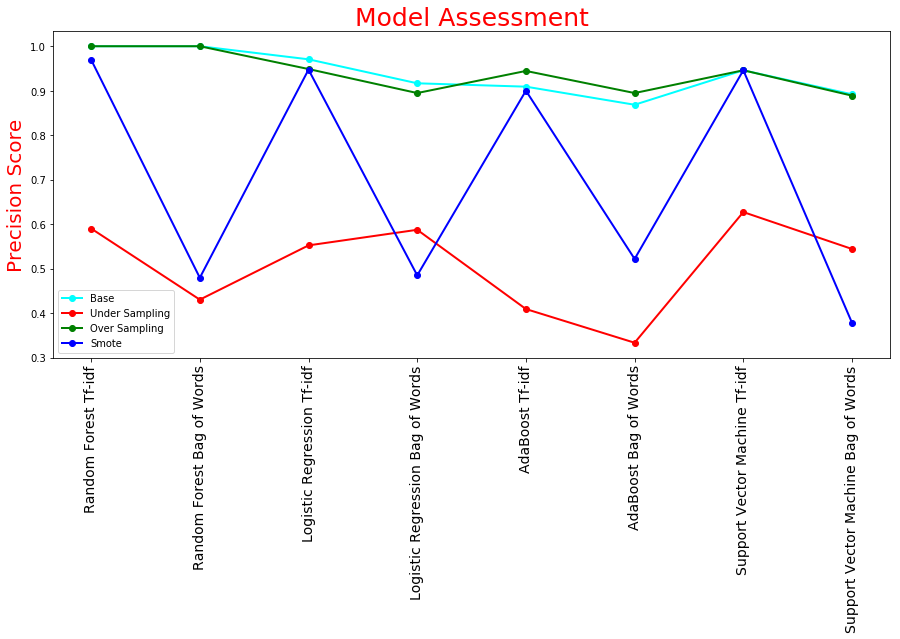

In [84]:
x = ['Random Forest Tf-idf', 'Random Forest Bag of Words', 'Logistic Regression Tf-idf', 'Logistic Regression Bag of Words', 'AdaBoost Tf-idf', 'AdaBoost Bag of Words', 'Support Vector Machine Tf-idf','Support Vector Machine Bag of Words']
y_base_preci = [forest_tfidf_base_preci, forest_cv_base_preci, log_tfidf_base_preci, log_cv_base_preci, ada_tfidf_base_preci, ada_cv_base_preci, svc_tfidf_base_preci, svc_cv_base_preci]
y_rus_preci = [forest_tfidf_rus_preci, forest_cv_rus_preci, log_tfidf_rus_preci, log_cv_rus_preci, ada_tfidf_rus_preci, ada_cv_rus_preci, svc_tfidf_rus_preci, svc_cv_rus_preci]
y_ros_preci = [forest_tfidf_ros_preci, forest_cv_ros_preci, log_tfidf_ros_preci, log_cv_ros_preci, ada_tfidf_ros_preci, ada_cv_ros_preci, svc_tfidf_ros_preci, svc_cv_ros_preci]
y_sm_preci = [forest_tfidf_sm_preci, forest_cv_sm_preci, log_tfidf_sm_preci, log_cv_sm_preci, ada_tfidf_sm_preci, ada_cv_sm_preci, svc_tfidf_sm_preci, svc_cv_sm_preci]

df=pd.DataFrame({'Models': x, 'Base': y_base_preci, 'Under Sampling': y_rus_preci, 'Over Sampling': y_ros_preci, 'Smote': y_sm_preci})

plt.figure(figsize=(15,6))
plt.plot( 'Models', 'Base', data=df, marker='o', markerfacecolor='cyan', color='cyan', linewidth=2)
plt.plot( 'Models', 'Under Sampling', data=df, marker='o',markerfacecolor='red', color='red', linewidth=2)
plt.plot( 'Models', 'Over Sampling', data=df, marker='o',markerfacecolor='green', color='green', linewidth=2)
plt.plot( 'Models', 'Smote', data=df, marker='o',markerfacecolor='blue', color='blue', linewidth=2,)
plt.ylabel('Precision Score',color = 'red',size = 20)
plt.title('Model Assessment', color = 'red', size = 25)
plt.xticks(x, rotation=90, color = 'black',size = 14)
plt.legend(loc=3)

# Recall Score

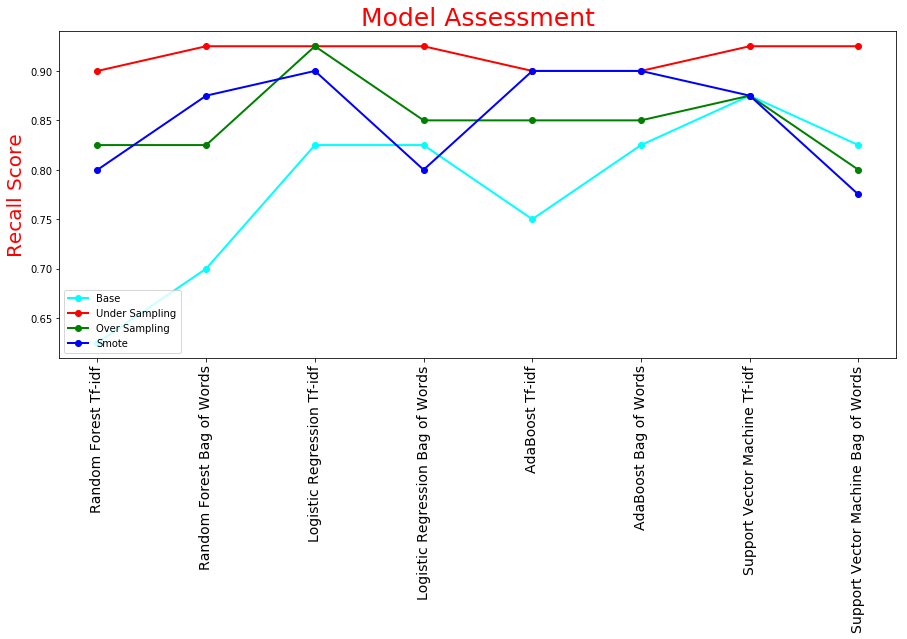

In [85]:
x = ['Random Forest Tf-idf', 'Random Forest Bag of Words', 'Logistic Regression Tf-idf', 'Logistic Regression Bag of Words', 'AdaBoost Tf-idf', 'AdaBoost Bag of Words', 'Support Vector Machine Tf-idf','Support Vector Machine Bag of Words']
y_base_rec = [forest_tfidf_base_rec, forest_cv_base_rec, log_tfidf_base_rec, log_cv_base_rec, ada_tfidf_base_rec, ada_cv_base_rec, svc_tfidf_base_rec, svc_cv_base_rec]
y_rus_rec = [forest_tfidf_rus_rec, forest_cv_rus_rec, log_tfidf_rus_rec, log_cv_rus_rec, ada_tfidf_rus_rec, ada_cv_rus_rec, svc_tfidf_rus_rec, svc_cv_rus_rec]
y_ros_rec = [forest_tfidf_ros_rec, forest_cv_ros_rec, log_tfidf_ros_rec, log_cv_ros_rec, ada_tfidf_ros_rec, ada_cv_ros_rec, svc_tfidf_ros_rec, svc_cv_ros_rec]
y_sm_rec = [forest_tfidf_sm_rec, forest_cv_sm_rec, log_tfidf_sm_rec, log_cv_sm_rec, ada_tfidf_sm_rec, ada_cv_sm_rec, svc_tfidf_sm_rec, svc_cv_sm_rec]

df=pd.DataFrame({'Models': x, 'Base': y_base_rec, 'Under Sampling': y_rus_rec, 'Over Sampling': y_ros_rec, 'Smote': y_sm_rec})

plt.figure(figsize=(15,6))
plt.plot( 'Models', 'Base', data=df, marker='o', markerfacecolor='cyan', color='cyan', linewidth=2)
plt.plot( 'Models', 'Under Sampling', data=df, marker='o',markerfacecolor='red', color='red', linewidth=2)
plt.plot( 'Models', 'Over Sampling', data=df, marker='o',markerfacecolor='green', color='green', linewidth=2)
plt.plot( 'Models', 'Smote', data=df, marker='o',markerfacecolor='blue', color='blue', linewidth=2,)
plt.ylabel('Recall Score',color = 'red',size = 20)
plt.title('Model Assessment', color = 'red', size = 25)
plt.xticks(x, rotation=90, color = 'black',size = 14)
plt.legend(loc=3)

# F1 Score

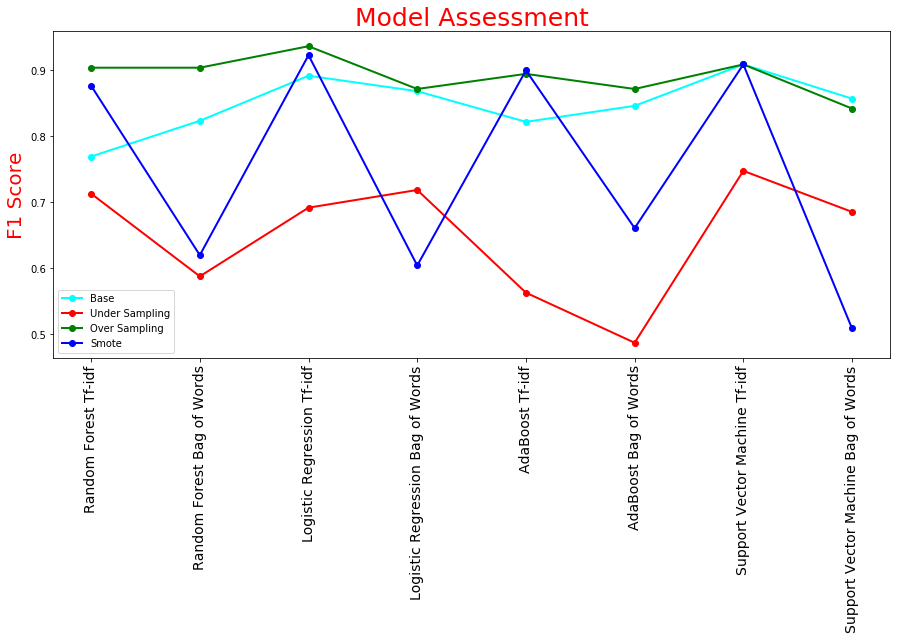

In [86]:
x = ['Random Forest Tf-idf', 'Random Forest Bag of Words', 'Logistic Regression Tf-idf', 'Logistic Regression Bag of Words', 'AdaBoost Tf-idf', 'AdaBoost Bag of Words', 'Support Vector Machine Tf-idf','Support Vector Machine Bag of Words']
y_base_f1 = [forest_tfidf_base_f1, forest_cv_base_f1, log_tfidf_base_f1, log_cv_base_f1, ada_tfidf_base_f1, ada_cv_base_f1, svc_tfidf_base_f1, svc_cv_base_f1]
y_rus_f1 = [forest_tfidf_rus_f1, forest_cv_rus_f1, log_tfidf_rus_f1, log_cv_rus_f1, ada_tfidf_rus_f1, ada_cv_rus_f1, svc_tfidf_rus_f1, svc_cv_rus_f1]
y_ros_f1 = [forest_tfidf_ros_f1, forest_cv_ros_f1, log_tfidf_ros_f1, log_cv_ros_f1, ada_tfidf_ros_f1, ada_cv_ros_f1, svc_tfidf_ros_f1, svc_cv_ros_f1]
y_sm_f1 = [forest_tfidf_sm_f1, forest_cv_sm_f1, log_tfidf_sm_f1, log_cv_sm_f1, ada_tfidf_sm_f1, ada_cv_sm_f1, svc_tfidf_sm_f1, svc_cv_sm_f1]

df=pd.DataFrame({'Models': x, 'Base': y_base_f1, 'Under Sampling': y_rus_f1, 'Over Sampling': y_ros_f1, 'Smote': y_sm_f1})

plt.figure(figsize=(15,6))
plt.plot( 'Models', 'Base', data=df, marker='o', markerfacecolor='cyan', color='cyan', linewidth=2)
plt.plot( 'Models', 'Under Sampling', data=df, marker='o',markerfacecolor='red', color='red', linewidth=2)
plt.plot( 'Models', 'Over Sampling', data=df, marker='o',markerfacecolor='green', color='green', linewidth=2)
plt.plot( 'Models', 'Smote', data=df, marker='o',markerfacecolor='blue', color='blue', linewidth=2,)
plt.ylabel('F1 Score',color = 'red',size = 20)
plt.title('Model Assessment', color = 'red', size = 25)
plt.xticks(x, rotation=90, color = 'black',size = 14)
plt.legend(loc=3)

In [87]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score

forest_tfidf_tr_base_pred = forest_tfidf.predict(train_data_features_tfidf)
forest_tfidf_tr_rus_pred = forest_tfidf_rus.predict(train_data_features_tfidf)
forest_tfidf_tr_ros_pred = forest_tfidf_ros.predict(train_data_features_tfidf)
forest_tfidf_tr_sm_pred = forest_tfidf_sm.predict(train_data_features_tfidf)

forest_cv_tr_base_pred = forest_cv.predict(train_data_features_cv)
forest_cv_tr_rus_pred = forest_cv_rus.predict(train_data_features_cv)
forest_cv_tr_ros_pred = forest_cv_ros.predict(train_data_features_cv)
forest_cv_tr_sm_pred = forest_cv_sm.predict(train_data_features_cv)

#precision_score(y_test, forest_tfidf_tr_base_pred)
forest_tfidf_tr_base_preci = precision_score(y_train, forest_tfidf_tr_base_pred)
forest_tfidf_tr_rus_preci = precision_score(y_train, forest_tfidf_tr_rus_pred)
forest_tfidf_tr_ros_preci = precision_score(y_train, forest_tfidf_tr_ros_pred)
forest_tfidf_tr_sm_preci = precision_score(y_train, forest_tfidf_tr_sm_pred)

forest_cv_tr_base_preci = precision_score(y_train, forest_cv_tr_base_pred)
forest_cv_tr_rus_preci = precision_score(y_train, forest_cv_tr_rus_pred)
forest_cv_tr_ros_preci = precision_score(y_train, forest_cv_tr_ros_pred)
forest_cv_tr_sm_preci = precision_score(y_train, forest_cv_tr_sm_pred)

forest_tfidf_tr_base_rec = recall_score(y_train, forest_tfidf_tr_base_pred)
forest_tfidf_tr_rus_rec = recall_score(y_train, forest_tfidf_tr_rus_pred)
forest_tfidf_tr_ros_rec = recall_score(y_train, forest_tfidf_tr_ros_pred)
forest_tfidf_tr_sm_rec = recall_score(y_train, forest_tfidf_tr_sm_pred)

forest_cv_tr_base_rec = recall_score(y_train, forest_cv_tr_base_pred)
forest_cv_tr_rus_rec = recall_score(y_train, forest_cv_tr_rus_pred)
forest_cv_tr_ros_rec = recall_score(y_train, forest_cv_tr_ros_pred)
forest_cv_tr_sm_rec = recall_score(y_train, forest_cv_tr_sm_pred)

forest_tfidf_tr_base_f1 = f1_score(y_train, forest_tfidf_tr_base_pred)
forest_tfidf_tr_rus_f1 = f1_score(y_train, forest_tfidf_tr_rus_pred)
forest_tfidf_tr_ros_f1 = f1_score(y_train, forest_tfidf_tr_ros_pred)
forest_tfidf_tr_sm_f1 = f1_score(y_train, forest_tfidf_tr_sm_pred)

forest_cv_tr_base_f1 = f1_score(y_train, forest_cv_tr_base_pred)
forest_cv_tr_rus_f1 = f1_score(y_train, forest_cv_tr_rus_pred)
forest_cv_tr_ros_f1 = f1_score(y_train, forest_cv_tr_ros_pred)
forest_cv_tr_sm_f1 = f1_score(y_train, forest_cv_tr_sm_pred)

forest_tfidf_tr_base_auc = accuracy_score(y_train, forest_tfidf_tr_base_pred)
forest_tfidf_tr_rus_auc = accuracy_score(y_train, forest_tfidf_tr_rus_pred)
forest_tfidf_tr_ros_auc = accuracy_score(y_train, forest_tfidf_tr_ros_pred)
forest_tfidf_tr_sm_auc = accuracy_score(y_train, forest_tfidf_tr_sm_pred)

forest_cv_tr_base_auc = accuracy_score(y_train, forest_cv_tr_base_pred)
forest_cv_tr_rus_auc = accuracy_score(y_train, forest_cv_tr_rus_pred)
forest_cv_tr_ros_auc = accuracy_score(y_train, forest_cv_tr_ros_pred)
forest_cv_tr_sm_auc = accuracy_score(y_train, forest_cv_tr_sm_pred)

In [88]:
svc_tfidf_tr_base_pred = svc_tfidf.predict(train_data_features_tfidf)
svc_tfidf_tr_rus_pred = svc_tfidf_rus.predict(train_data_features_tfidf)
svc_tfidf_tr_ros_pred = svc_tfidf_ros.predict(train_data_features_tfidf)
svc_tfidf_tr_sm_pred = svc_tfidf_sm.predict(train_data_features_tfidf)

svc_cv_tr_base_pred = svc_cv.predict(train_data_features_cv)
svc_cv_tr_rus_pred = svc_cv_rus.predict(train_data_features_cv)
svc_cv_tr_ros_pred = svc_cv_ros.predict(train_data_features_cv)
svc_cv_tr_sm_pred = svc_cv_sm.predict(train_data_features_cv)

svc_tfidf_tr_base_preci = precision_score(y_train, svc_tfidf_tr_base_pred)
svc_tfidf_tr_rus_preci = precision_score(y_train, svc_tfidf_tr_rus_pred)
svc_tfidf_tr_ros_preci = precision_score(y_train, svc_tfidf_tr_ros_pred)
svc_tfidf_tr_sm_preci = precision_score(y_train, svc_tfidf_tr_sm_pred)

svc_cv_tr_base_preci = precision_score(y_train, svc_cv_tr_base_pred)
svc_cv_tr_rus_preci = precision_score(y_train, svc_cv_tr_rus_pred)
svc_cv_tr_ros_preci = precision_score(y_train, svc_cv_tr_ros_pred)
svc_cv_tr_sm_preci = precision_score(y_train, svc_cv_tr_sm_pred)

svc_tfidf_tr_base_rec = recall_score(y_train, svc_tfidf_tr_base_pred)
svc_tfidf_tr_rus_rec = recall_score(y_train, svc_tfidf_tr_rus_pred)
svc_tfidf_tr_ros_rec = recall_score(y_train, svc_tfidf_tr_ros_pred)
svc_tfidf_tr_sm_rec = recall_score(y_train, svc_tfidf_tr_sm_pred)

svc_cv_tr_base_rec = recall_score(y_train, svc_cv_tr_base_pred)
svc_cv_tr_rus_rec = recall_score(y_train, svc_cv_tr_rus_pred)
svc_cv_tr_ros_rec = recall_score(y_train, svc_cv_tr_ros_pred)
svc_cv_tr_sm_rec = recall_score(y_train, svc_cv_tr_sm_pred)

svc_tfidf_tr_base_f1 = f1_score(y_train, svc_tfidf_tr_base_pred)
svc_tfidf_tr_rus_f1 = f1_score(y_train, svc_tfidf_tr_rus_pred)
svc_tfidf_tr_ros_f1 = f1_score(y_train, svc_tfidf_tr_ros_pred)
svc_tfidf_tr_sm_f1 = f1_score(y_train, svc_tfidf_tr_sm_pred)

svc_cv_tr_base_f1 = f1_score(y_train, svc_cv_tr_base_pred)
svc_cv_tr_rus_f1 = f1_score(y_train, svc_cv_tr_rus_pred)
svc_cv_tr_ros_f1 = f1_score(y_train, svc_cv_tr_ros_pred)
svc_cv_tr_sm_f1 = f1_score(y_train, svc_cv_tr_sm_pred)

svc_tfidf_tr_base_auc = accuracy_score(y_train, svc_tfidf_tr_base_pred)
svc_tfidf_tr_rus_auc = accuracy_score(y_train, svc_tfidf_tr_rus_pred)
svc_tfidf_tr_ros_auc = accuracy_score(y_train, svc_tfidf_tr_ros_pred)
svc_tfidf_tr_sm_auc = accuracy_score(y_train, svc_tfidf_tr_sm_pred)

svc_cv_tr_base_auc = accuracy_score(y_train, svc_cv_tr_base_pred)
svc_cv_tr_rus_auc = accuracy_score(y_train, svc_cv_tr_rus_pred)
svc_cv_tr_ros_auc = accuracy_score(y_train, svc_cv_tr_ros_pred)
svc_cv_tr_sm_auc = accuracy_score(y_train, svc_cv_tr_sm_pred)

In [89]:
ada_tfidf_tr_base_pred = ada_tfidf.predict(train_data_features_tfidf)
ada_tfidf_tr_rus_pred = ada_tfidf_rus.predict(train_data_features_tfidf)
ada_tfidf_tr_ros_pred = ada_tfidf_ros.predict(train_data_features_tfidf)
ada_tfidf_tr_sm_pred = ada_tfidf_sm.predict(train_data_features_tfidf)

ada_cv_tr_base_pred = ada_cv.predict(train_data_features_cv)
ada_cv_tr_rus_pred = ada_cv_rus.predict(train_data_features_cv)
ada_cv_tr_ros_pred = ada_cv_ros.predict(train_data_features_cv)
ada_cv_tr_sm_pred = ada_cv_sm.predict(train_data_features_cv)

ada_tfidf_tr_base_preci = precision_score(y_train, ada_tfidf_tr_base_pred)
ada_tfidf_tr_rus_preci = precision_score(y_train, ada_tfidf_tr_rus_pred)
ada_tfidf_tr_ros_preci = precision_score(y_train, ada_tfidf_tr_ros_pred)
ada_tfidf_tr_sm_preci = precision_score(y_train, ada_tfidf_tr_sm_pred)

ada_cv_tr_base_preci = precision_score(y_train, ada_cv_tr_base_pred)
ada_cv_tr_rus_preci = precision_score(y_train, ada_cv_tr_rus_pred)
ada_cv_tr_ros_preci = precision_score(y_train, ada_cv_tr_ros_pred)
ada_cv_tr_sm_preci = precision_score(y_train, ada_cv_tr_sm_pred)

ada_tfidf_tr_base_rec = recall_score(y_train, ada_tfidf_tr_base_pred)
ada_tfidf_tr_rus_rec = recall_score(y_train, ada_tfidf_tr_rus_pred)
ada_tfidf_tr_ros_rec = recall_score(y_train, ada_tfidf_tr_ros_pred)
ada_tfidf_tr_sm_rec = recall_score(y_train, ada_tfidf_tr_sm_pred)

ada_cv_tr_base_rec = recall_score(y_train, ada_cv_tr_base_pred)
ada_cv_tr_rus_rec = recall_score(y_train, ada_cv_tr_rus_pred)
ada_cv_tr_ros_rec = recall_score(y_train, ada_cv_tr_ros_pred)
ada_cv_tr_sm_rec = recall_score(y_train, ada_cv_tr_sm_pred)

ada_tfidf_tr_base_f1 = f1_score(y_train, ada_tfidf_tr_base_pred)
ada_tfidf_tr_rus_f1 = f1_score(y_train, ada_tfidf_tr_rus_pred)
ada_tfidf_tr_ros_f1 = f1_score(y_train, ada_tfidf_tr_ros_pred)
ada_tfidf_tr_sm_f1 = f1_score(y_train, ada_tfidf_tr_sm_pred)

ada_cv_tr_base_f1 = f1_score(y_train, ada_cv_tr_base_pred)
ada_cv_tr_rus_f1 = f1_score(y_train, ada_cv_tr_rus_pred)
ada_cv_tr_ros_f1 = f1_score(y_train, ada_cv_tr_ros_pred)
ada_cv_tr_sm_f1 = f1_score(y_train, ada_cv_tr_sm_pred)

ada_tfidf_tr_base_auc = accuracy_score(y_train, ada_tfidf_tr_base_pred)
ada_tfidf_tr_rus_auc = accuracy_score(y_train, ada_tfidf_tr_rus_pred)
ada_tfidf_tr_ros_auc = accuracy_score(y_train, ada_tfidf_tr_ros_pred)
ada_tfidf_tr_sm_auc = accuracy_score(y_train, ada_tfidf_tr_sm_pred)

ada_cv_tr_base_auc = accuracy_score(y_train, ada_cv_tr_base_pred)
ada_cv_tr_rus_auc = accuracy_score(y_train, ada_cv_tr_rus_pred)
ada_cv_tr_ros_auc = accuracy_score(y_train, ada_cv_tr_ros_pred)
ada_cv_tr_sm_auc = accuracy_score(y_train, ada_cv_tr_sm_pred)

In [90]:
log_tfidf_tr_base_pred = log_tfidf.predict(train_data_features_tfidf)
log_tfidf_tr_rus_pred = log_tfidf_rus.predict(train_data_features_tfidf)
log_tfidf_tr_ros_pred = log_tfidf_ros.predict(train_data_features_tfidf)
log_tfidf_tr_sm_pred = log_tfidf_sm.predict(train_data_features_tfidf)

log_cv_tr_base_pred = log_cv.predict(train_data_features_cv)
log_cv_tr_rus_pred = log_cv_rus.predict(train_data_features_cv)
log_cv_tr_ros_pred = log_cv_ros.predict(train_data_features_cv)
log_cv_tr_sm_pred = log_cv_sm.predict(train_data_features_cv)

log_tfidf_tr_base_preci = precision_score(y_train, log_tfidf_tr_base_pred)
log_tfidf_tr_rus_preci = precision_score(y_train, log_tfidf_tr_rus_pred)
log_tfidf_tr_ros_preci = precision_score(y_train, log_tfidf_tr_ros_pred)
log_tfidf_tr_sm_preci = precision_score(y_train, log_tfidf_tr_sm_pred)

log_cv_tr_base_preci = precision_score(y_train, log_cv_tr_base_pred)
log_cv_tr_rus_preci = precision_score(y_train, log_cv_tr_rus_pred)
log_cv_tr_ros_preci = precision_score(y_train, log_cv_tr_ros_pred)
log_cv_tr_sm_preci = precision_score(y_train, log_cv_tr_sm_pred)

log_tfidf_tr_base_rec = recall_score(y_train, log_tfidf_tr_base_pred)
log_tfidf_tr_rus_rec = recall_score(y_train, log_tfidf_tr_rus_pred)
log_tfidf_tr_ros_rec = recall_score(y_train, log_tfidf_tr_ros_pred)
log_tfidf_tr_sm_rec = recall_score(y_train, log_tfidf_tr_sm_pred)

log_cv_tr_base_rec = recall_score(y_train, log_cv_tr_base_pred)
log_cv_tr_rus_rec = recall_score(y_train, log_cv_tr_rus_pred)
log_cv_tr_ros_rec = recall_score(y_train, log_cv_tr_ros_pred)
log_cv_tr_sm_rec = recall_score(y_train, log_cv_tr_sm_pred)

log_tfidf_tr_base_f1 = f1_score(y_train, log_tfidf_tr_base_pred)
log_tfidf_tr_rus_f1 = f1_score(y_train, log_tfidf_tr_rus_pred)
log_tfidf_tr_ros_f1 = f1_score(y_train, log_tfidf_tr_ros_pred)
log_tfidf_tr_sm_f1 = f1_score(y_train, log_tfidf_tr_sm_pred)

log_cv_tr_base_f1 = f1_score(y_train, log_cv_tr_base_pred)
log_cv_tr_rus_f1 = f1_score(y_train, log_cv_tr_rus_pred)
log_cv_tr_ros_f1 = f1_score(y_train, log_cv_tr_ros_pred)
log_cv_tr_sm_f1 = f1_score(y_train, log_cv_tr_sm_pred)

log_tfidf_tr_base_auc = accuracy_score(y_train, log_tfidf_tr_base_pred)
log_tfidf_tr_rus_auc = accuracy_score(y_train, log_tfidf_tr_rus_pred)
log_tfidf_tr_ros_auc = accuracy_score(y_train, log_tfidf_tr_ros_pred)
log_tfidf_tr_sm_auc = accuracy_score(y_train, log_tfidf_tr_sm_pred)

log_cv_tr_base_auc = accuracy_score(y_train, log_cv_tr_base_pred)
log_cv_tr_rus_auc = accuracy_score(y_train, log_cv_tr_rus_pred)
log_cv_tr_ros_auc = accuracy_score(y_train, log_cv_tr_ros_pred)
log_cv_tr_sm_auc = accuracy_score(y_train, log_cv_tr_sm_pred)

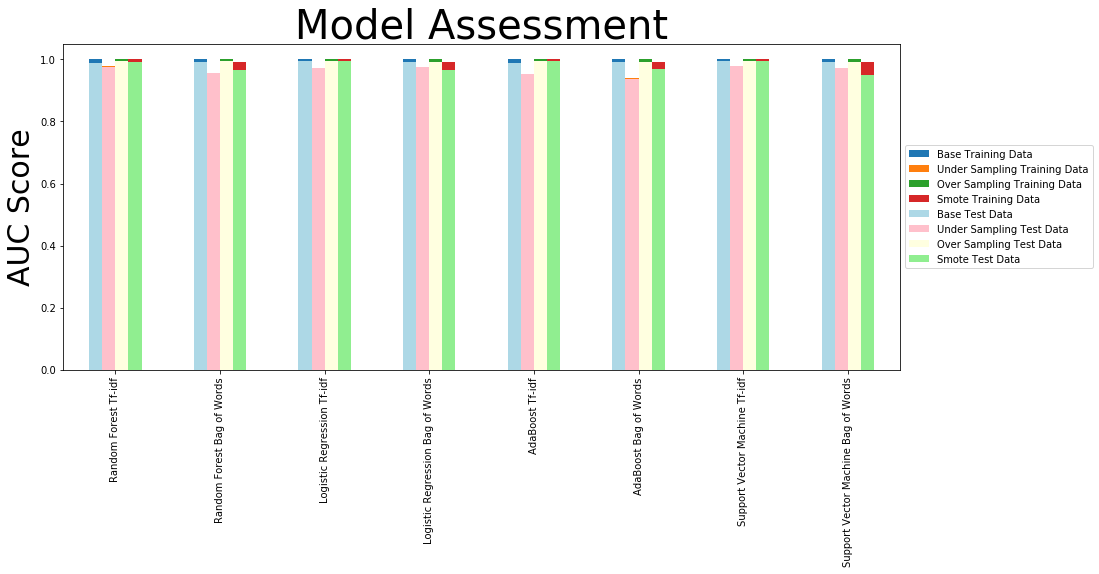

In [91]:
x = ['Random Forest Tf-idf', 'Random Forest Bag of Words', 'Logistic Regression Tf-idf', 'Logistic Regression Bag of Words', 'AdaBoost Tf-idf', 'AdaBoost Bag of Words', 'Support Vector Machine Tf-idf','Support Vector Machine Bag of Words']
y_base_auc = [forest_tfidf_base_auc, forest_cv_base_auc, log_tfidf_base_auc, log_cv_base_auc, ada_tfidf_base_auc, ada_cv_base_auc, svc_tfidf_base_auc, svc_cv_base_auc]
y_rus_auc = [forest_tfidf_rus_auc, forest_cv_rus_auc, log_tfidf_rus_auc, log_cv_rus_auc, ada_tfidf_rus_auc, ada_cv_rus_auc, svc_tfidf_rus_auc, svc_cv_rus_auc]
y_ros_auc = [forest_tfidf_ros_auc, forest_cv_ros_auc, log_tfidf_ros_auc, log_cv_ros_auc, ada_tfidf_ros_auc, ada_cv_ros_auc, svc_tfidf_ros_auc, svc_cv_ros_auc]
y_sm_auc = [forest_tfidf_sm_auc, forest_cv_sm_auc, log_tfidf_sm_auc, log_cv_sm_auc, ada_tfidf_sm_auc, ada_cv_sm_auc, svc_tfidf_sm_auc, svc_cv_sm_auc]
df_auc_ts=pd.DataFrame({'Models': x, 'Base Test Data': y_base_auc, 'Under Sampling Test Data': y_rus_auc, 'Over Sampling Test Data': y_ros_auc, 'Smote Test Data': y_sm_auc}, index = x)


y_base_auc_tr = [forest_tfidf_tr_base_auc, forest_cv_tr_base_auc, log_tfidf_tr_base_auc, log_cv_tr_base_auc, ada_tfidf_tr_base_auc, ada_cv_tr_base_auc, svc_tfidf_tr_base_auc, svc_cv_tr_base_auc]
y_rus_auc_tr = [forest_tfidf_tr_rus_auc, forest_cv_tr_rus_auc, log_tfidf_tr_rus_auc, log_cv_tr_rus_auc, ada_tfidf_tr_rus_auc, ada_cv_tr_rus_auc, svc_tfidf_tr_rus_auc, svc_cv_tr_rus_auc]
y_ros_auc_tr = [forest_tfidf_tr_ros_auc, forest_cv_tr_ros_auc, log_tfidf_tr_ros_auc, log_cv_tr_ros_auc, ada_tfidf_tr_ros_auc, ada_cv_tr_ros_auc, svc_tfidf_tr_ros_auc, svc_cv_tr_ros_auc]
y_sm_auc_tr = [forest_tfidf_tr_sm_auc, forest_cv_tr_sm_auc, log_tfidf_tr_sm_auc, log_cv_tr_sm_auc, ada_tfidf_tr_sm_auc, ada_cv_tr_sm_auc, svc_tfidf_tr_sm_auc, svc_cv_tr_sm_auc]
df_auc_tr=pd.DataFrame({'Base Training Data': y_base_auc_tr, 'Under Sampling Training Data': y_rus_auc_tr, 'Over Sampling Training Data': y_ros_auc_tr, 'Smote Training Data': y_sm_auc_tr}, index=x)

df_auc_birlesik = pd.DataFrame({'Base Test Data': y_base_auc,
                                'Base Training Data': y_base_auc_tr,
                                'Under Sampling Test Data': y_rus_auc,
                                'Under Sampling Training Data': y_rus_auc_tr,
                                'Over Sampling Test Data': y_ros_auc,
                                'Over Sampling Training Data': y_ros_auc_tr,
                                'Smote Test Data': y_sm_auc,
                                'Smote Training Data': y_sm_auc_tr}, index = x)


ax = df_auc_tr.plot.bar(figsize=(15,6))
df_auc_ts.plot.bar(ax=ax ,color=['lightblue', 'pink', 'lightyellow','lightgreen'])
ax.set_ylabel('AUC Score',size=30)
ax.set_title('Model Assessment',size=40)
#for p in ax.patches:
#    ax.annotate(str(p.get_height())[:4], (p.get_x() * 1, p.get_height() * 1))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

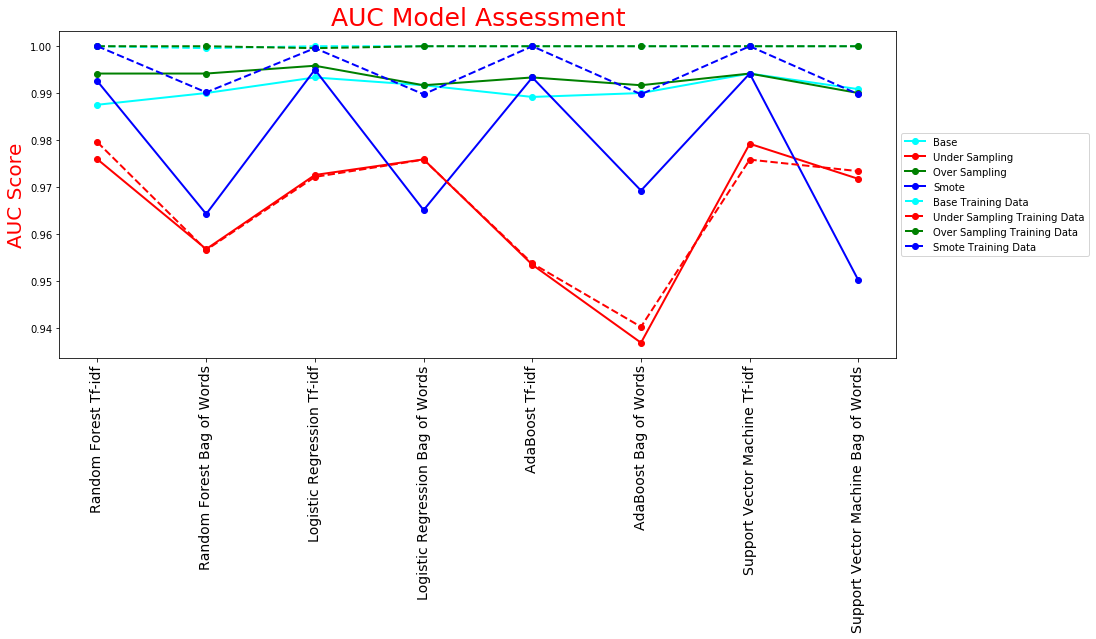

In [92]:
x = ['Random Forest Tf-idf', 'Random Forest Bag of Words', 'Logistic Regression Tf-idf', 'Logistic Regression Bag of Words', 'AdaBoost Tf-idf', 'AdaBoost Bag of Words', 'Support Vector Machine Tf-idf','Support Vector Machine Bag of Words']
y_base_auc = [forest_tfidf_base_auc, forest_cv_base_auc, log_tfidf_base_auc, log_cv_base_auc, ada_tfidf_base_auc, ada_cv_base_auc, svc_tfidf_base_auc, svc_cv_base_auc]
y_rus_auc = [forest_tfidf_rus_auc, forest_cv_rus_auc, log_tfidf_rus_auc, log_cv_rus_auc, ada_tfidf_rus_auc, ada_cv_rus_auc, svc_tfidf_rus_auc, svc_cv_rus_auc]
y_ros_auc = [forest_tfidf_ros_auc, forest_cv_ros_auc, log_tfidf_ros_auc, log_cv_ros_auc, ada_tfidf_ros_auc, ada_cv_ros_auc, svc_tfidf_ros_auc, svc_cv_ros_auc]
y_sm_auc = [forest_tfidf_sm_auc, forest_cv_sm_auc, log_tfidf_sm_auc, log_cv_sm_auc, ada_tfidf_sm_auc, ada_cv_sm_auc, svc_tfidf_sm_auc, svc_cv_sm_auc]

df=pd.DataFrame({'Models': x, 'Base': y_base_auc, 'Under Sampling': y_rus_auc, 'Over Sampling': y_ros_auc, 'Smote': y_sm_auc})





y_base_auc_tr = [forest_tfidf_tr_base_auc, forest_cv_tr_base_auc, log_tfidf_tr_base_auc, log_cv_tr_base_auc, ada_tfidf_tr_base_auc, ada_cv_tr_base_auc, svc_tfidf_tr_base_auc, svc_cv_tr_base_auc]
y_rus_auc_tr = [forest_tfidf_tr_rus_auc, forest_cv_tr_rus_auc, log_tfidf_tr_rus_auc, log_cv_tr_rus_auc, ada_tfidf_tr_rus_auc, ada_cv_tr_rus_auc, svc_tfidf_tr_rus_auc, svc_cv_tr_rus_auc]
y_ros_auc_tr = [forest_tfidf_tr_ros_auc, forest_cv_tr_ros_auc, log_tfidf_tr_ros_auc, log_cv_tr_ros_auc, ada_tfidf_tr_ros_auc, ada_cv_tr_ros_auc, svc_tfidf_tr_ros_auc, svc_cv_tr_ros_auc]
y_sm_auc_tr = [forest_tfidf_tr_sm_auc, forest_cv_tr_sm_auc, log_tfidf_tr_sm_auc, log_cv_tr_sm_auc, ada_tfidf_tr_sm_auc, ada_cv_tr_sm_auc, svc_tfidf_tr_sm_auc, svc_cv_tr_sm_auc]

df_auc_tr=pd.DataFrame({'Models': x, 'Base Training Data': y_base_auc_tr, 'Under Sampling Training Data': y_rus_auc_tr, 'Over Sampling Training Data': y_ros_auc_tr, 'Smote Training Data': y_sm_auc_tr})

plt.figure(figsize=(15,6))
plt.plot( 'Models', 'Base', data=df, marker='o', markerfacecolor='cyan', color='cyan', linewidth=2)
plt.plot( 'Models', 'Under Sampling', data=df, marker='o',markerfacecolor='red', color='red', linewidth=2)
plt.plot( 'Models', 'Over Sampling', data=df, marker='o',markerfacecolor='green', color='green', linewidth=2)
plt.plot( 'Models', 'Smote', data=df, marker='o',markerfacecolor='blue', color='blue', linewidth=2,)

plt.plot( 'Models', 'Base Training Data', data=df_auc_tr, linestyle='--',marker='o', markerfacecolor='cyan', color='cyan', linewidth=2)
plt.plot( 'Models', 'Under Sampling Training Data', data=df_auc_tr, linestyle='--', marker='o',markerfacecolor='red', color='red', linewidth=2)
plt.plot( 'Models', 'Over Sampling Training Data', data=df_auc_tr,linestyle='--', marker='o',markerfacecolor='green', color='green', linewidth=2)
plt.plot( 'Models', 'Smote Training Data', data=df_auc_tr,linestyle='--',
         marker='o',markerfacecolor='blue', color='blue', linewidth=2,)
plt.ylabel('AUC Score',color = 'red',size = 20)
plt.title('AUC Model Assessment', color = 'red', size = 25)
plt.xticks(x, rotation=90, color = 'black',size = 14)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#plt.savefig('deneme.pdf', format='pdf', dpi=1000)

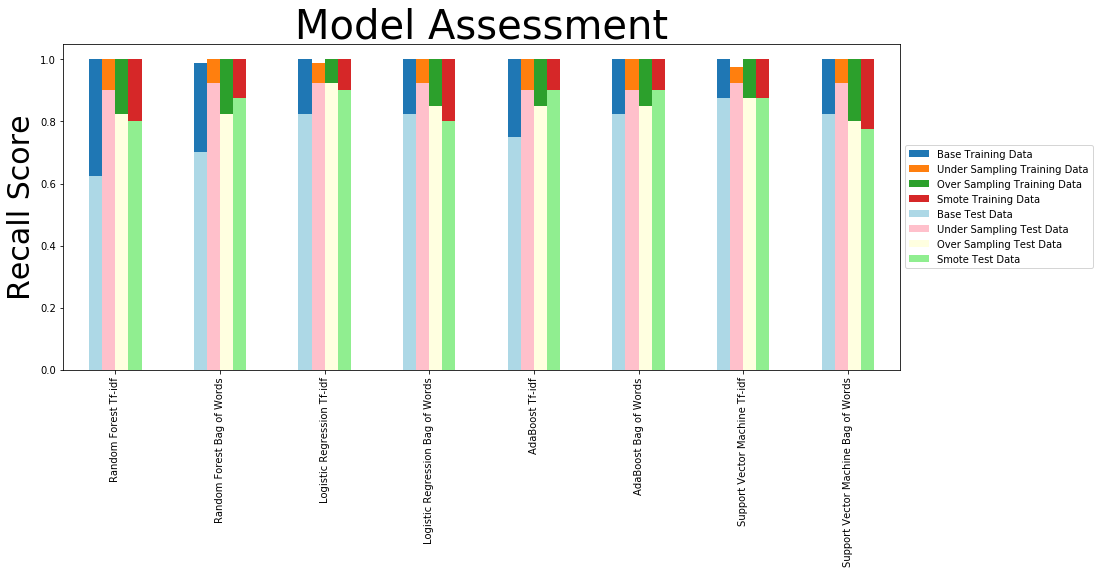

In [93]:
x = ['Random Forest Tf-idf', 'Random Forest Bag of Words', 'Logistic Regression Tf-idf', 'Logistic Regression Bag of Words', 'AdaBoost Tf-idf', 'AdaBoost Bag of Words', 'Support Vector Machine Tf-idf','Support Vector Machine Bag of Words']
y_base_rec = [forest_tfidf_base_rec, forest_cv_base_rec, log_tfidf_base_rec, log_cv_base_rec, ada_tfidf_base_rec, ada_cv_base_rec, svc_tfidf_base_rec, svc_cv_base_rec]
y_rus_rec = [forest_tfidf_rus_rec, forest_cv_rus_rec, log_tfidf_rus_rec, log_cv_rus_rec, ada_tfidf_rus_rec, ada_cv_rus_rec, svc_tfidf_rus_rec, svc_cv_rus_rec]
y_ros_rec = [forest_tfidf_ros_rec, forest_cv_ros_rec, log_tfidf_ros_rec, log_cv_ros_rec, ada_tfidf_ros_rec, ada_cv_ros_rec, svc_tfidf_ros_rec, svc_cv_ros_rec]
y_sm_rec = [forest_tfidf_sm_rec, forest_cv_sm_rec, log_tfidf_sm_rec, log_cv_sm_rec, ada_tfidf_sm_rec, ada_cv_sm_rec, svc_tfidf_sm_rec, svc_cv_sm_rec]
df_rec_ts=pd.DataFrame({'Models': x, 'Base Test Data': y_base_rec, 'Under Sampling Test Data': y_rus_rec, 'Over Sampling Test Data': y_ros_rec, 'Smote Test Data': y_sm_rec}, index = x)


y_base_rec_tr = [forest_tfidf_tr_base_rec, forest_cv_tr_base_rec, log_tfidf_tr_base_rec, log_cv_tr_base_rec, ada_tfidf_tr_base_rec, ada_cv_tr_base_rec, svc_tfidf_tr_base_rec, svc_cv_tr_base_rec]
y_rus_rec_tr = [forest_tfidf_tr_rus_rec, forest_cv_tr_rus_rec, log_tfidf_tr_rus_rec, log_cv_tr_rus_rec, ada_tfidf_tr_rus_rec, ada_cv_tr_rus_rec, svc_tfidf_tr_rus_rec, svc_cv_tr_rus_rec]
y_ros_rec_tr = [forest_tfidf_tr_ros_rec, forest_cv_tr_ros_rec, log_tfidf_tr_ros_rec, log_cv_tr_ros_rec, ada_tfidf_tr_ros_rec, ada_cv_tr_ros_rec, svc_tfidf_tr_ros_rec, svc_cv_tr_ros_rec]
y_sm_rec_tr = [forest_tfidf_tr_sm_rec, forest_cv_tr_sm_rec, log_tfidf_tr_sm_rec, log_cv_tr_sm_rec, ada_tfidf_tr_sm_rec, ada_cv_tr_sm_rec, svc_tfidf_tr_sm_rec, svc_cv_tr_sm_rec]
df_rec_tr=pd.DataFrame({'Base Training Data': y_base_rec_tr, 'Under Sampling Training Data': y_rus_rec_tr, 'Over Sampling Training Data': y_ros_rec_tr, 'Smote Training Data': y_sm_rec_tr}, index=x)

df_rec_birlesik = pd.DataFrame({'Base Test Data': y_base_rec,
                                'Base Training Data': y_base_rec_tr,
                                'Under Sampling Test Data': y_rus_rec,
                                'Under Sampling Training Data': y_rus_rec_tr,
                                'Over Sampling Test Data': y_ros_rec,
                                'Over Sampling Training Data': y_ros_rec_tr,
                                'Smote Test Data': y_sm_rec,
                                'Smote Training Data': y_sm_rec_tr}, index = x)


ax = df_rec_tr.plot.bar(figsize=(15,6))
df_rec_ts.plot.bar(ax=ax ,color=['lightblue', 'pink', 'lightyellow','lightgreen'])
ax.set_ylabel('Recall Score',size=30)
ax.set_title('Model Assessment',size=40)
#for p in ax.patches:
#    ax.annotate(str(p.get_height())[:4], (p.get_x() * 1, p.get_height() * 1))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

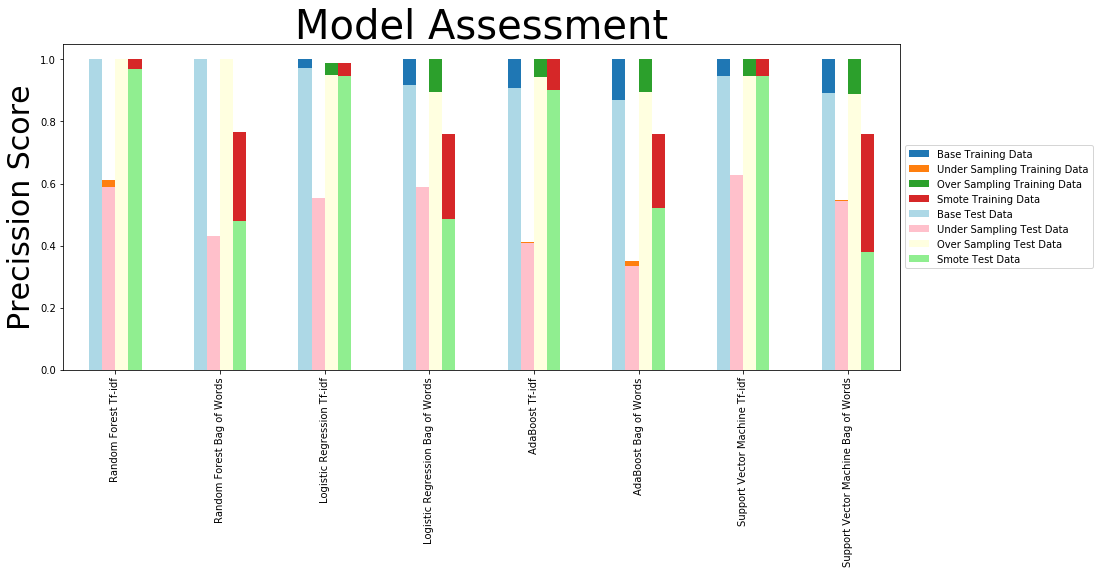

In [94]:
x = ['Random Forest Tf-idf', 'Random Forest Bag of Words', 'Logistic Regression Tf-idf', 'Logistic Regression Bag of Words', 'AdaBoost Tf-idf', 'AdaBoost Bag of Words', 'Support Vector Machine Tf-idf','Support Vector Machine Bag of Words']
y_base_preci = [forest_tfidf_base_preci, forest_cv_base_preci, log_tfidf_base_preci, log_cv_base_preci, ada_tfidf_base_preci, ada_cv_base_preci, svc_tfidf_base_preci, svc_cv_base_preci]
y_rus_preci = [forest_tfidf_rus_preci, forest_cv_rus_preci, log_tfidf_rus_preci, log_cv_rus_preci, ada_tfidf_rus_preci, ada_cv_rus_preci, svc_tfidf_rus_preci, svc_cv_rus_preci]
y_ros_preci = [forest_tfidf_ros_preci, forest_cv_ros_preci, log_tfidf_ros_preci, log_cv_ros_preci, ada_tfidf_ros_preci, ada_cv_ros_preci, svc_tfidf_ros_preci, svc_cv_ros_preci]
y_sm_preci = [forest_tfidf_sm_preci, forest_cv_sm_preci, log_tfidf_sm_preci, log_cv_sm_preci, ada_tfidf_sm_preci, ada_cv_sm_preci, svc_tfidf_sm_preci, svc_cv_sm_preci]
df_preci_ts=pd.DataFrame({'Models': x, 'Base Test Data': y_base_preci, 'Under Sampling Test Data': y_rus_preci, 'Over Sampling Test Data': y_ros_preci, 'Smote Test Data': y_sm_preci}, index = x)


y_base_preci_tr = [forest_tfidf_tr_base_preci, forest_cv_tr_base_preci, log_tfidf_tr_base_preci, log_cv_tr_base_preci, ada_tfidf_tr_base_preci, ada_cv_tr_base_preci, svc_tfidf_tr_base_preci, svc_cv_tr_base_preci]
y_rus_preci_tr = [forest_tfidf_tr_rus_preci, forest_cv_tr_rus_preci, log_tfidf_tr_rus_preci, log_cv_tr_rus_preci, ada_tfidf_tr_rus_preci, ada_cv_tr_rus_preci, svc_tfidf_tr_rus_preci, svc_cv_tr_rus_preci]
y_ros_preci_tr = [forest_tfidf_tr_ros_preci, forest_cv_tr_ros_preci, log_tfidf_tr_ros_preci, log_cv_tr_ros_preci, ada_tfidf_tr_ros_preci, ada_cv_tr_ros_preci, svc_tfidf_tr_ros_preci, svc_cv_tr_ros_preci]
y_sm_preci_tr = [forest_tfidf_tr_sm_preci, forest_cv_tr_sm_preci, log_tfidf_tr_sm_preci, log_cv_tr_sm_preci, ada_tfidf_tr_sm_preci, ada_cv_tr_sm_preci, svc_tfidf_tr_sm_preci, svc_cv_tr_sm_preci]
df_preci_tr=pd.DataFrame({'Base Training Data': y_base_preci_tr, 'Under Sampling Training Data': y_rus_preci_tr, 'Over Sampling Training Data': y_ros_preci_tr, 'Smote Training Data': y_sm_preci_tr}, index=x)


df_preci_birlesik = pd.DataFrame({'Base Test Data': y_base_preci,
                                'Base Training Data': y_base_preci_tr,
                                'Under Sampling Test Data': y_rus_preci,
                                'Under Sampling Training Data': y_rus_preci_tr,
                                'Over Sampling Test Data': y_ros_preci,
                                'Over Sampling Training Data': y_ros_preci_tr,
                                'Smote Test Data': y_sm_preci,
                                'Smote Training Data': y_sm_preci_tr}, index = x)

ax = df_preci_tr.plot.bar(figsize=(15,6))
df_preci_ts.plot.bar(ax=ax ,color=['lightblue', 'pink', 'lightyellow','lightgreen'])
ax.set_ylabel('Precission Score',size=30)
ax.set_title('Model Assessment',size=40)
#for p in ax.patches:
#    ax.annotate(str(p.get_height())[:4], (p.get_x() * 1, p.get_height() * 1))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# F1 Score

In [95]:
print('------------------------------------------Accuracy Scores--------------------------------------')
df_auc_birlesik

------------------------------------------Accuracy Scores--------------------------------------


,Base Test Data,Base Training Data,Under Sampling Test Data,Under Sampling Training Data,Over Sampling Test Data,Over Sampling Training Data,Smote Test Data,Smote Training Data
Random Forest Tf-idf,0.987531,1.00000,0.975894,0.979525,0.994181,1.00000,0.992519,1.000000
Random Forest Bag of Words,0.990025,0.99959,0.956775,0.956593,0.994181,1.00000,0.964256,0.990172
Logistic Regression Tf-idf,0.993350,1.00000,0.972569,0.972154,0.995844,0.99959,0.995012,0.999590
Logistic Regression Bag of Words,0.991687,1.00000,0.975894,0.975839,0.991687,1.00000,0.965087,0.989762
AdaBoost Tf-idf,0.989194,1.00000,0.953450,0.953726,0.993350,1.00000,0.993350,1.000000
AdaBoost Bag of Words,0.990025,1.00000,0.936825,0.940213,0.991687,1.00000,0.969244,0.989762
Support Vector Machine Tf-idf,0.994181,1.00000,0.979219,0.975839,0.994181,1.00000,0.994181,1.000000
Support Vector Machine Bag of Words,0.990856,1.00000,0.971737,0.973382,0.990025,1.00000,0.950125,0.989762


In [96]:
print('------------------------------------------Precission Scores--------------------------------------')
df_preci_birlesik

------------------------------------------Precission Scores--------------------------------------


,Base Test Data,Base Training Data,Under Sampling Test Data,Under Sampling Training Data,Over Sampling Test Data,Over Sampling Training Data,Smote Test Data,Smote Training Data
Random Forest Tf-idf,1.000000,1.0,0.590164,0.612403,1.000000,1.0000,0.969697,1.000000
Random Forest Bag of Words,1.000000,1.0,0.430233,0.427027,1.000000,1.0000,0.479452,0.766990
Logistic Regression Tf-idf,0.970588,1.0,0.552239,0.537931,0.948718,0.9875,0.947368,0.987500
Logistic Regression Bag of Words,0.916667,1.0,0.587302,0.572464,0.894737,1.0000,0.484848,0.759615
AdaBoost Tf-idf,0.909091,1.0,0.409091,0.411458,0.944444,1.0000,0.900000,1.000000
AdaBoost Bag of Words,0.868421,1.0,0.333333,0.351111,0.894737,1.0000,0.521739,0.759615
Support Vector Machine Tf-idf,0.945946,1.0,0.627119,0.574627,0.945946,1.0000,0.945946,1.000000
Support Vector Machine Bag of Words,0.891892,1.0,0.544118,0.548611,0.888889,1.0000,0.378049,0.759615


In [97]:
print('------------------------------------------Recall Scores--------------------------------------')
df_rec_birlesik

------------------------------------------Recall Scores--------------------------------------


,Base Test Data,Base Training Data,Under Sampling Test Data,Under Sampling Training Data,Over Sampling Test Data,Over Sampling Training Data,Smote Test Data,Smote Training Data
Random Forest Tf-idf,0.625,1.000000,0.900,1.000000,0.825,1.0,0.800,1.0
Random Forest Bag of Words,0.700,0.987342,0.925,1.000000,0.825,1.0,0.875,1.0
Logistic Regression Tf-idf,0.825,1.000000,0.925,0.987342,0.925,1.0,0.900,1.0
Logistic Regression Bag of Words,0.825,1.000000,0.925,1.000000,0.850,1.0,0.800,1.0
AdaBoost Tf-idf,0.750,1.000000,0.900,1.000000,0.850,1.0,0.900,1.0
AdaBoost Bag of Words,0.825,1.000000,0.900,1.000000,0.850,1.0,0.900,1.0
Support Vector Machine Tf-idf,0.875,1.000000,0.925,0.974684,0.875,1.0,0.875,1.0
Support Vector Machine Bag of Words,0.825,1.000000,0.925,1.000000,0.800,1.0,0.775,1.0


In [98]:
confusion_matrix(y_test, log_tfidf_base_pred)

array([[1162,    1],
       [   7,   33]])

In [99]:
# accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(ada_tfidf, train_data_features_tfidf, y_train, cv=5))
# use AUC as scoring metric
print('Cross-validation (F1_score)', cross_val_score(ada_cv_ros, X_rosampled_cv, y_rosampled_cv, cv=5, scoring = 'f1'))
# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(ada_tfidf, train_data_features_tfidf, y_train, cv=5, scoring = 'recall'))

Cross-validation (accuracy) [0.99386503 0.98977505 0.98568507 0.98770492 0.99178645]
Cross-validation (F1_score) [1.         0.99578947 0.9978903  0.9989418  0.9989418 ]
Cross-validation (recall) [0.8125     0.6875     0.75       0.625      0.93333333]


In [100]:
f1_cr_base_ada_tfidf = cross_val_score(ada_tfidf, train_data_features_tfidf, y_train, cv=5, scoring = 'f1').mean()
f1_cr_base_ada_cv = cross_val_score(ada_cv, train_data_features_cv, y_train, cv=5, scoring = 'f1').mean()
f1_cr_rus_ada_tfidf = cross_val_score(ada_tfidf_rus, X_rusampled_tfidf, y_rusampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_rus_ada_cv = cross_val_score(ada_cv_rus, X_rusampled_cv, y_rusampled_cv, cv=5, scoring = 'f1').mean() 
f1_cr_ros_ada_tfidf = cross_val_score(ada_tfidf_ros, X_rosampled_tfidf, y_rosampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_ros_ada_cv = cross_val_score(ada_cv_ros, X_rosampled_cv, y_rosampled_cv, cv=5, scoring = 'f1').mean() 
f1_cr_sm_ada_tfidf = cross_val_score(ada_tfidf_sm, X_smsampled_tfidf, y_smsampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_sm_ada_cv = cross_val_score(ada_cv_sm, X_smsampled_cv, y_smsampled_cv, cv=5, scoring = 'f1').mean() 


In [101]:
f1_cr_base_log_tfidf = cross_val_score(log_tfidf, train_data_features_tfidf, y_train, cv=5, scoring = 'f1').mean() 
f1_cr_base_log_cv = cross_val_score(log_cv, train_data_features_cv, y_train, cv=5, scoring = 'f1').mean() 
f1_cr_rus_log_tfidf = cross_val_score(log_tfidf_rus, X_rusampled_tfidf, y_rusampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_rus_log_cv = cross_val_score(log_cv_rus, X_rusampled_cv, y_rusampled_cv, cv=5, scoring = 'f1').mean() 
f1_cr_ros_log_tfidf = cross_val_score(log_tfidf_ros, X_rosampled_tfidf, y_rosampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_ros_log_cv = cross_val_score(log_cv_ros, X_rosampled_cv, y_rosampled_cv, cv=5, scoring = 'f1').mean() 
f1_cr_sm_log_tfidf = cross_val_score(log_tfidf_sm, X_smsampled_tfidf, y_smsampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_sm_log_cv = cross_val_score(log_cv_sm, X_smsampled_cv, y_smsampled_cv, cv=5, scoring = 'f1').mean() 


/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

In [102]:
f1_cr_base_svc_tfidf = cross_val_score(svc_tfidf, train_data_features_tfidf, y_train, cv=5, scoring = 'f1').mean() 
f1_cr_base_svc_cv = cross_val_score(svc_cv, train_data_features_cv, y_train, cv=5, scoring = 'f1').mean() 
f1_cr_rus_svc_tfidf = cross_val_score(svc_tfidf_rus, X_rusampled_tfidf, y_rusampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_rus_svc_cv = cross_val_score(svc_cv_rus, X_rusampled_cv, y_rusampled_cv, cv=5, scoring = 'f1').mean() 
f1_cr_ros_svc_tfidf = cross_val_score(svc_tfidf_ros, X_rosampled_tfidf, y_rosampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_ros_svc_cv = cross_val_score(svc_cv_ros, X_rosampled_cv, y_rosampled_cv, cv=5, scoring = 'f1').mean() 
f1_cr_sm_svc_tfidf = cross_val_score(svc_tfidf_sm, X_smsampled_tfidf, y_smsampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_sm_svc_cv = cross_val_score(svc_cv_sm, X_smsampled_cv, y_smsampled_cv, cv=5, scoring = 'f1').mean() 


In [103]:
f1_cr_base_forest_tfidf = cross_val_score(forest_tfidf, train_data_features_tfidf, y_train, cv=5, scoring = 'f1').mean() 
f1_cr_base_forest_cv = cross_val_score(forest_cv, train_data_features_cv, y_train, cv=5, scoring = 'f1').mean() 
f1_cr_rus_forest_tfidf = cross_val_score(forest_tfidf_rus, X_rusampled_tfidf, y_rusampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_rus_forest_cv = cross_val_score(forest_cv_rus, X_rusampled_cv, y_rusampled_cv, cv=5, scoring = 'f1').mean() 
f1_cr_ros_forest_tfidf = cross_val_score(forest_tfidf_ros, X_rosampled_tfidf, y_rosampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_ros_forest_cv = cross_val_score(forest_cv_ros, X_rosampled_cv, y_rosampled_cv, cv=5, scoring = 'f1').mean() 
f1_cr_sm_forest_tfidf = cross_val_score(forest_tfidf_sm, X_smsampled_tfidf, y_smsampled_tfidf, cv=5, scoring = 'f1').mean() 
f1_cr_sm_forest_cv = cross_val_score(forest_cv_sm, X_smsampled_cv, y_smsampled_cv, cv=5, scoring = 'f1').mean() 


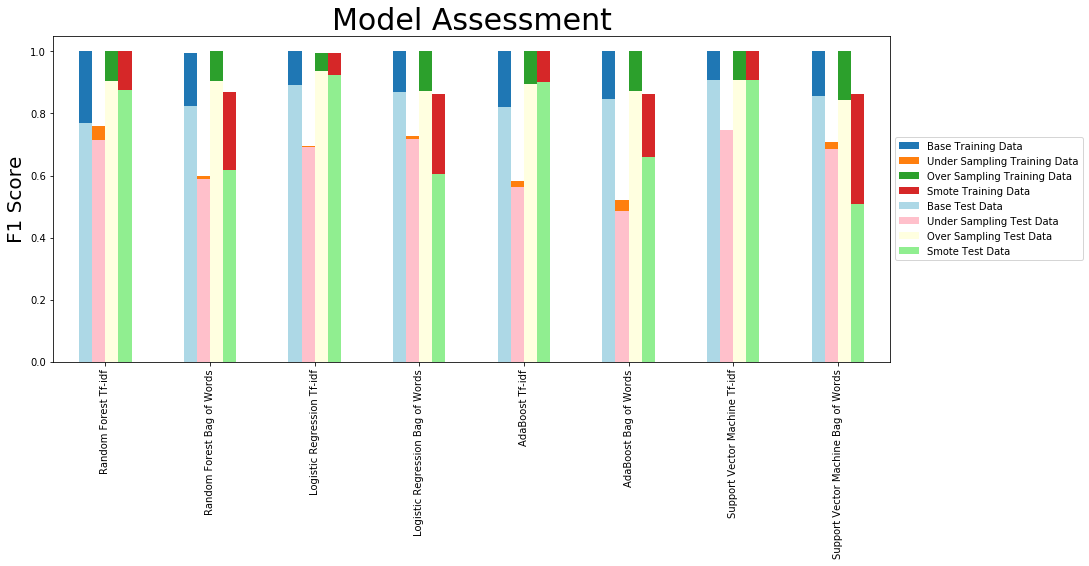

In [104]:
x = ['Random Forest Tf-idf', 'Random Forest Bag of Words', 'Logistic Regression Tf-idf', 'Logistic Regression Bag of Words', 'AdaBoost Tf-idf', 'AdaBoost Bag of Words', 'Support Vector Machine Tf-idf','Support Vector Machine Bag of Words']
y_base_f1 = [forest_tfidf_base_f1, forest_cv_base_f1, log_tfidf_base_f1, log_cv_base_f1, ada_tfidf_base_f1, ada_cv_base_f1, svc_tfidf_base_f1, svc_cv_base_f1]
y_rus_f1 = [forest_tfidf_rus_f1, forest_cv_rus_f1, log_tfidf_rus_f1, log_cv_rus_f1, ada_tfidf_rus_f1, ada_cv_rus_f1, svc_tfidf_rus_f1, svc_cv_rus_f1]
y_ros_f1 = [forest_tfidf_ros_f1, forest_cv_ros_f1, log_tfidf_ros_f1, log_cv_ros_f1, ada_tfidf_ros_f1, ada_cv_ros_f1, svc_tfidf_ros_f1, svc_cv_ros_f1]
y_sm_f1 = [forest_tfidf_sm_f1, forest_cv_sm_f1, log_tfidf_sm_f1, log_cv_sm_f1, ada_tfidf_sm_f1, ada_cv_sm_f1, svc_tfidf_sm_f1, svc_cv_sm_f1]
df_f1_ts=pd.DataFrame({'Models': x, 'Base Test Data': y_base_f1, 'Under Sampling Test Data': y_rus_f1, 'Over Sampling Test Data': y_ros_f1, 'Smote Test Data': y_sm_f1}, index = x)


y_base_f1_tr = [forest_tfidf_tr_base_f1, forest_cv_tr_base_f1, log_tfidf_tr_base_f1, log_cv_tr_base_f1, ada_tfidf_tr_base_f1, ada_cv_tr_base_f1, svc_tfidf_tr_base_f1, svc_cv_tr_base_f1]
y_rus_f1_tr = [forest_tfidf_tr_rus_f1, forest_cv_tr_rus_f1, log_tfidf_tr_rus_f1, log_cv_tr_rus_f1, ada_tfidf_tr_rus_f1, ada_cv_tr_rus_f1, svc_tfidf_tr_rus_f1, svc_cv_tr_rus_f1]
y_ros_f1_tr = [forest_tfidf_tr_ros_f1, forest_cv_tr_ros_f1, log_tfidf_tr_ros_f1, log_cv_tr_ros_f1, ada_tfidf_tr_ros_f1, ada_cv_tr_ros_f1, svc_tfidf_tr_ros_f1, svc_cv_tr_ros_f1]
y_sm_f1_tr = [forest_tfidf_tr_sm_f1, forest_cv_tr_sm_f1, log_tfidf_tr_sm_f1, log_cv_tr_sm_f1, ada_tfidf_tr_sm_f1, ada_cv_tr_sm_f1, svc_tfidf_tr_sm_f1, svc_cv_tr_sm_f1]
df_f1_tr=pd.DataFrame({'Base Training Data': y_base_f1_tr, 'Under Sampling Training Data': y_rus_f1_tr, 'Over Sampling Training Data': y_ros_f1_tr, 'Smote Training Data': y_sm_f1_tr}, index=x)

y_base_f1_cr = [f1_cr_base_forest_tfidf, f1_cr_base_forest_cv, f1_cr_base_log_tfidf, f1_cr_base_log_cv, f1_cr_base_ada_tfidf, f1_cr_base_ada_cv, f1_cr_base_svc_tfidf, f1_cr_base_svc_cv]
y_rus_f1_cr = [f1_cr_rus_forest_tfidf, f1_cr_rus_forest_cv, f1_cr_rus_log_tfidf, f1_cr_rus_log_cv, f1_cr_rus_ada_tfidf, f1_cr_rus_ada_cv, f1_cr_rus_svc_tfidf, f1_cr_rus_svc_cv]
y_ros_f1_cr = [f1_cr_ros_forest_tfidf, f1_cr_ros_forest_cv, f1_cr_ros_log_tfidf, f1_cr_ros_log_cv, f1_cr_ros_ada_tfidf, f1_cr_ros_ada_cv, f1_cr_ros_svc_tfidf, f1_cr_ros_svc_cv]
y_sm_f1_cr = [f1_cr_sm_forest_tfidf, f1_cr_sm_forest_cv, f1_cr_sm_log_tfidf, f1_cr_sm_log_cv, f1_cr_sm_ada_tfidf, f1_cr_sm_ada_cv, f1_cr_sm_svc_tfidf, f1_cr_sm_svc_cv]
df_f1_birlesik = pd.DataFrame({'Base Test Data': y_base_f1,
                                'Base Cross Validation Data': y_base_f1_cr,
                                'Base Training Data': y_base_f1_tr,
                                'Under Sampling Test Data': y_rus_f1,
                                'Under Cross Validation Data': y_rus_f1_cr,
                                'Under Sampling Training Data': y_rus_f1_tr,
                                'Over Sampling Test Data': y_ros_f1,
                                'Over Cross Validation Data': y_ros_f1_cr,
                                'Over Sampling Training Data': y_ros_f1_tr,
                                'Smote Test Data': y_sm_f1,
                                'Smote Cross Validation Data': y_sm_f1_cr,
                                'Smote Training Data': y_sm_f1_tr}, index = x)

ax = df_f1_tr.plot.bar(figsize=(15,6))
df_f1_ts.plot.bar(ax=ax ,color=['lightblue', 'pink', 'lightyellow','lightgreen'])
ax.set_ylabel('F1 Score',size=20)
ax.set_title('Model Assessment',size=30)
#for p in ax.patches:
#    ax.annotate(str(p.get_height())[:4], (p.get_x() * 1, p.get_height() * 1))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [105]:
print('------------------------------------------F1 Scores--------------------------------------')
df_f1_birlesik

------------------------------------------F1 Scores--------------------------------------


,Base Test Data,Base Cross Validation Data,Base Training Data,Under Sampling Test Data,Under Cross Validation Data,Under Sampling Training Data,Over Sampling Test Data,Over Cross Validation Data,Over Sampling Training Data,Smote Test Data,Smote Cross Validation Data,Smote Training Data
Random Forest Tf-idf,0.769231,0.752919,1.000000,0.712871,0.936387,0.759615,0.904110,0.999577,1.000000,0.876712,0.998079,1.000000
Random Forest Bag of Words,0.823529,0.805142,0.993631,0.587302,0.941478,0.598485,0.904110,1.000000,1.000000,0.619469,0.984101,0.868132
Logistic Regression Tf-idf,0.891892,0.878110,1.000000,0.691589,0.968548,0.696429,0.936709,0.999367,0.993711,0.923077,0.999789,0.993711
Logistic Regression Bag of Words,0.868421,0.906490,1.000000,0.718447,0.935887,0.728111,0.871795,0.999366,1.000000,0.603774,0.986620,0.863388
AdaBoost Tf-idf,0.821918,0.825958,1.000000,0.562500,0.925057,0.583026,0.894737,0.999366,1.000000,0.900000,0.997662,1.000000
AdaBoost Bag of Words,0.846154,0.898740,1.000000,0.486486,0.940171,0.519737,0.871795,0.998313,1.000000,0.660550,0.982505,0.863388
Support Vector Machine Tf-idf,0.909091,0.932814,1.000000,0.747475,0.955645,0.723005,0.909091,0.999789,1.000000,0.909091,0.999789,1.000000
Support Vector Machine Bag of Words,0.857143,0.913934,1.000000,0.685185,0.928145,0.708520,0.842105,0.999789,1.000000,0.508197,0.979675,0.863388


In [106]:
import time
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [0.0001, 0.001, 0.01, 1, 2,5,10,20,30,50,100,200,500]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 10, n_jobs=-1,scoring = 'f1')

start_time = time.time()
grid_result = grid.fit(X_rosampled_tfidf,y_rosampled_tfidf)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.999789 using {'C': 10, 'dual': True, 'max_iter': 100}
Execution time: 31.071123361587524 ms


/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [107]:
import time
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [0.0001, 0.001, 0.01, 1, 2,5,10,20,30,50,100,200,500]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 10, n_jobs=-1,scoring = 'f1')

start_time = time.time()
grid_result = grid.fit(X_rusampled_tfidf,y_rusampled_tfidf)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.961926 using {'C': 1, 'dual': True, 'max_iter': 100}
Execution time: 1.1151201725006104 ms


/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [108]:
import time
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [0.0001, 0.001, 0.01, 1, 2,5,10,20,30,50,100,200,500]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 10, n_jobs=-1,scoring = 'f1')

start_time = time.time()
grid_result = grid.fit(X_smsampled_tfidf,y_smsampled_tfidf)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.999789 using {'C': 5, 'dual': True, 'max_iter': 100}
Execution time: 31.303146839141846 ms


/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [109]:
import time
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [0.0001, 0.001, 0.01, 1, 2,5,10,20,30,50,100,200,500]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 10, n_jobs=-1,scoring = 'f1')

start_time = time.time()
grid_result = grid.fit(X_smsampled_cv,y_smsampled_cv)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best: 0.988076 using {'C': 500, 'dual': True, 'max_iter': 130}
Execution time: 42.72419285774231 ms


/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [110]:
import time
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [0.0001, 0.001, 0.01, 1, 2,5,10,20,30,50,100,200,500]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 10, n_jobs=-1,scoring = 'f1')

start_time = time.time()
grid_result = grid.fit(X_rusampled_cv,y_rusampled_cv)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.935815 using {'C': 1, 'dual': True, 'max_iter': 100}
Execution time: 1.241896629333496 ms


/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [111]:
import time
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [0.0001, 0.001, 0.01, 1, 2,5,10,20,30,50,100,200,500]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 10, n_jobs=-1,scoring = 'f1')

start_time = time.time()
grid_result = grid.fit(X_rosampled_cv,y_rosampled_cv)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.999578 using {'C': 200, 'dual': False, 'max_iter': 100}
Execution time: 37.842339515686035 ms


/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [112]:
import time
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [0.0001, 0.001, 0.01, 1, 2,5,10,20,30,50,100,200,500]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 10, n_jobs=-1,scoring = 'f1')

start_time = time.time()
grid_result = grid.fit(train_data_features_tfidf, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

/home/melih/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.908191 using {'C': 500, 'dual': True, 'max_iter': 100}
Execution time: 14.315000057220459 ms


/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [113]:
import time
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [0.0001, 0.001, 0.01, 1, 2,5,10,20,30,50,100,200,500]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 10, n_jobs=-1,scoring = 'f1')

start_time = time.time()
grid_result = grid.fit(train_data_features_cv, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.921663 using {'C': 20, 'dual': True, 'max_iter': 100}
Execution time: 18.265195846557617 ms


/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [114]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [5,10,20,25,30,35,50,100,150,200],
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1,cv= 5,scoring='f1')
CV_rfc.fit(X_rusampled_tfidf,y_rusampled_tfidf)
CV_rfc.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 150}

In [115]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [5,10,20,25,30,35,50,100,150,200],
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1,cv= 5,scoring='f1')
CV_rfc.fit(X_rosampled_tfidf,y_rosampled_tfidf)
CV_rfc.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/melih/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 100}

In [116]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [5,10,20,25,30,35,50,100,150,200],
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1,cv= 5,scoring='f1')
CV_rfc.fit(X_smsampled_tfidf,y_smsampled_tfidf)
CV_rfc.best_params_

{'n_estimators': 100}

In [117]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [5,10,20,25,30,35,50,100,150,200],
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1,cv= 5,scoring='f1')
CV_rfc.fit(X_smsampled_cv,y_smsampled_cv)
CV_rfc.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 100}

In [118]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [5,10,20,25,30,35,50,100,150,200],
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1,cv= 5,scoring='f1')
CV_rfc.fit(X_rosampled_cv,y_rosampled_cv)
CV_rfc.best_params_

{'n_estimators': 30}

In [119]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [5,10,20,25,30,35,50,100,150,200],
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1,cv= 5,scoring='f1')
CV_rfc.fit(X_rusampled_cv,y_rusampled_cv)
CV_rfc.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 150}

In [120]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [5,10,20,25,30,35,50,100,150,200],
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1,cv= 5,scoring='f1')
CV_rfc.fit(train_data_features_cv, y_train)
CV_rfc.best_params_

{'n_estimators': 50}

In [121]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [5,10,20,25,30,35,50,100,150,200],
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1,cv= 5,scoring='f1')
CV_rfc.fit(train_data_features_tfidf, y_train)
CV_rfc.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 25}

In [122]:
param_grid = {
              "n_estimators": [1, 2,5,10,20,30,50,60,70,80,90,100,150,200,250,300,400,500]
             }



ABC = AdaBoostClassifier(base_estimator = None)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1,scoring = 'f1')
grid_search_ABC.fit(train_data_features_tfidf,y_train)
grid_search_ABC.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 500}

In [123]:
param_grid = {
              "n_estimators": [1, 2,5,10,20,30,50,60,70,80,90,100,150,200,250,300,400,500]
             }



ABC = AdaBoostClassifier(base_estimator = None)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1,scoring = 'f1')
grid_search_ABC.fit(train_data_features_cv,y_train)
grid_search_ABC.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 300}

In [124]:
param_grid = {
              "n_estimators": [1, 2,5,10,20,30,50,60,70,80,90,100,150,200,250,300,400,500]
             }



ABC = AdaBoostClassifier(base_estimator = None)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1,scoring = 'f1')
grid_search_ABC.fit(X_rusampled_cv,y_rusampled_cv)
grid_search_ABC.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 20}

In [125]:
param_grid = {
              "n_estimators": [1, 2,5,10,20,30,50,60,70,80,90,100,150,200,250,300,400,500]
             }



ABC = AdaBoostClassifier(base_estimator = None)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1,scoring = 'f1')
grid_search_ABC.fit(X_rosampled_cv,y_rosampled_cv)
grid_search_ABC.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 500}

In [126]:
param_grid = {
              "n_estimators": [1, 2,5,10,20,30,50,60,70,80,90,100,150,200,250,300,400,500]
             }



ABC = AdaBoostClassifier(base_estimator = None)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1,scoring = 'f1')
grid_search_ABC.fit(X_smsampled_cv,y_smsampled_cv)
grid_search_ABC.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 300}

In [127]:
param_grid = {
              "n_estimators": [1, 2,5,10,20,30,50,60,70,80,90,100,150,200,250,300,400,500]
             }



ABC = AdaBoostClassifier(base_estimator = None)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1,scoring = 'f1')
grid_search_ABC.fit(X_smsampled_tfidf,y_smsampled_tfidf)
grid_search_ABC.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 400}

In [128]:
param_grid = {
              "n_estimators": [1, 2,5,10,20,30,50,60,70,80,90,100,150,200,250,300,400,500]
             }



ABC = AdaBoostClassifier(base_estimator = None)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1,scoring = 'f1')
grid_search_ABC.fit(X_rosampled_tfidf,y_rosampled_tfidf)
grid_search_ABC.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 400}

In [129]:
param_grid = {
              "n_estimators": [1, 2,5,10,20,30,50,60,70,80,90,100,150,200,250,300,400,500]
             }



ABC = AdaBoostClassifier(base_estimator = None)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1,scoring = 'f1')
grid_search_ABC.fit(X_rusampled_tfidf,y_rusampled_tfidf)
grid_search_ABC.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 50}

In [130]:
from __future__ import print_function

from sklearn import datasets
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, n_jobs=-1,scoring=score)
    clf.fit(train_data_features_tfidf, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1

Best parameters set found on development set:

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)



In [131]:
from __future__ import print_function

from sklearn import datasets
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, n_jobs=-1,scoring=score)
    clf.fit(train_data_features_cv, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1



/home/melih/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



In [132]:
from __future__ import print_function

from sklearn import datasets
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, n_jobs=-1,scoring=score)
    clf.fit(X_rusampled_tfidf,y_rusampled_tfidf)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1

Best parameters set found on development set:

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [133]:
from __future__ import print_function

from sklearn import datasets
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, n_jobs=-1,scoring=score)
    clf.fit(X_rosampled_tfidf,y_rosampled_tfidf)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1



/home/melih/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/melih/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/melih/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



In [134]:
from __future__ import print_function

from sklearn import datasets
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, n_jobs=-1,scoring=score)
    clf.fit(X_smsampled_tfidf,y_smsampled_tfidf)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1

Best parameters set found on development set:

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



In [135]:
from __future__ import print_function

from sklearn import datasets
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, n_jobs=-1,scoring=score)
    clf.fit(X_smsampled_cv,y_smsampled_cv)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1

Best parameters set found on development set:

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



In [136]:
from __future__ import print_function

from sklearn import datasets
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, n_jobs=-1,scoring=score)
    clf.fit(X_rosampled_cv,y_rosampled_cv)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1

Best parameters set found on development set:

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



In [137]:
from __future__ import print_function

from sklearn import datasets
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, n_jobs=-1,scoring=score)
    clf.fit(X_rusampled_cv,y_rusampled_cv)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1

Best parameters set found on development set:

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [138]:
param_grid = {
              "n_estimators": [1, 2,5,10,20,30,50,60,70,80,90,100,150,200,250,300,400,500]
             }



ABC = AdaBoostClassifier(base_estimator = None)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'f1')
grid_search_ABC.fit(train_data_features_tfidf,y_train)
grid_search_ABC.best_params_

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 400}

In [139]:


param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }


DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "auto",max_depth = None)

ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc')

# Dummy Classifier For Controling 

In [140]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(train_data_features_cv, y_train)
y_dummy_predictions = dummy_majority.predict(test_data_features_cv)


dummy_cv = confusion_matrix(y_test, y_dummy_predictions)
print('-----------Dummy Classifier For Testing-----------------')
print('Confusion Matrix CV')
print('\tPredictions CV')
print('\t{:>5}\t{:>5}'.format(0,1))
for row_id, real_row in enumerate(dummy_cv):
    print('{}\t{:>5}\t{:>5}'.format(row_id, real_row[0], real_row[1]))

-----------Dummy Classifier For Testing-----------------
Confusion Matrix CV
	Predictions CV
	    0	    1
0	 1163	    0
1	   40	    0


Dummy stratified
--------------------
Training Performance
-> Acc: 0.9418509418509419
-> AUC: 0.49784654778039067
Testing Performance
-> Acc: 0.938984438984439
-> AUC: 0.4970227858985382



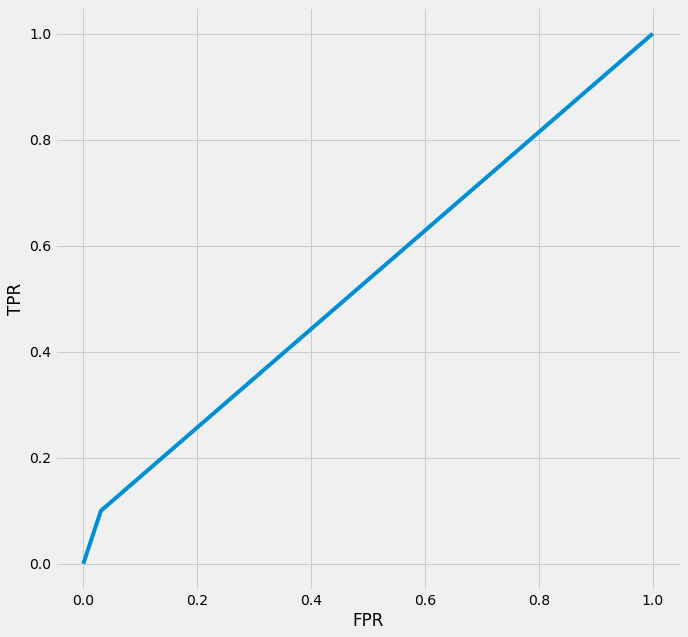

Dummy most_frequent
--------------------
Training Performance
-> Acc: 0.9676494676494677
-> AUC: 0.5
Testing Performance
-> Acc: 0.9676494676494677
-> AUC: 0.5



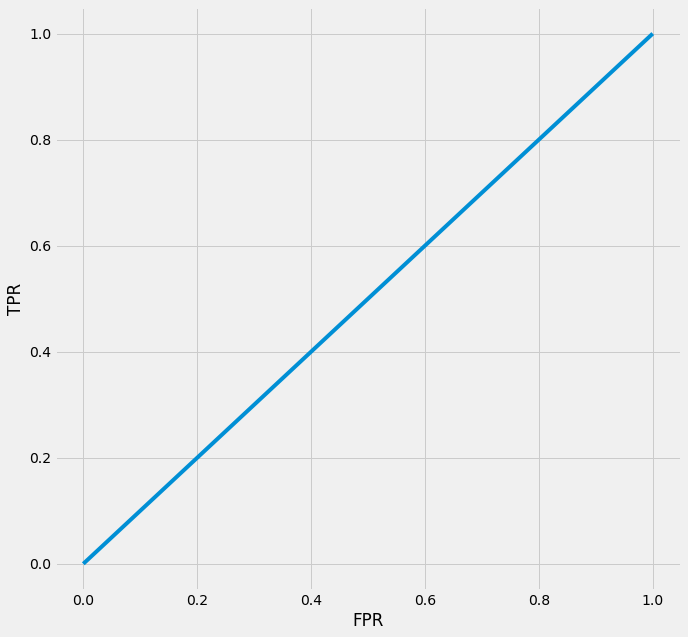

Dummy prior
--------------------
Training Performance
-> Acc: 0.9676494676494677
-> AUC: 0.5
Testing Performance
-> Acc: 0.9676494676494677
-> AUC: 0.5



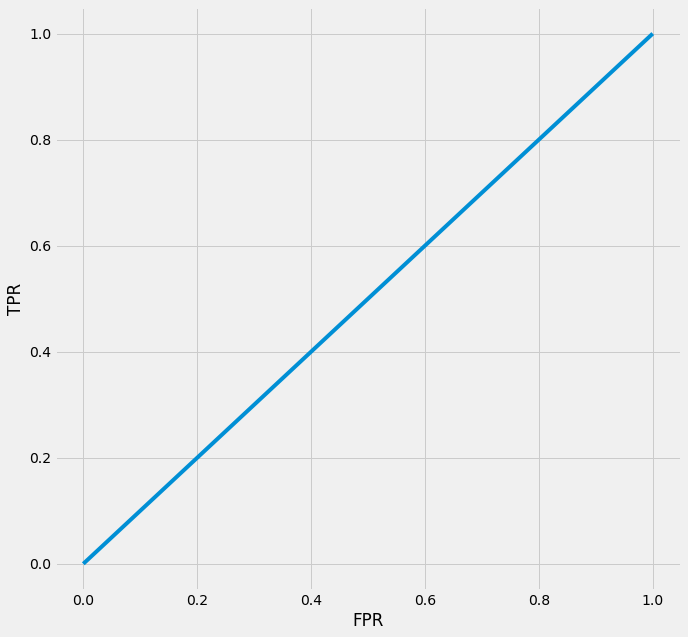

Dummy uniform
--------------------
Training Performance
-> Acc: 0.5171990171990172
-> AUC: 0.5
Testing Performance
-> Acc: 0.5184275184275184
-> AUC: 0.5



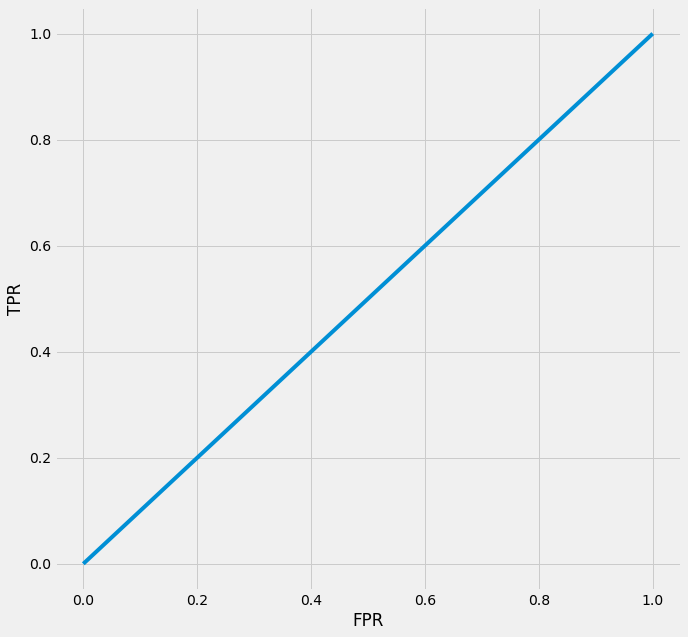

In [141]:


graph.style.use('fivethirtyeight')
def judge_model(model, name, plot=False):
    print(name)
    print('-'*20)
    
    print('Training Performance')
    print('-> Acc:', accuracy_score(y_train, model.predict(train_data_features_tfidf)) )
    print('-> AUC:', roc_auc_score(y_train, model.predict_proba(train_data_features_tfidf)[:, 1] ))
    
    print('Testing Performance')
    print('-> Acc:', accuracy_score(y_train, model.predict(train_data_features_tfidf)) )
    print('-> AUC:', roc_auc_score(y_test, model.predict_proba(test_data_features_tfidf)[:, 1] ))
    print()
    
    if plot:
        fpr, tpr, thres = roc_curve(y_test, model.predict_proba(test_data_features_tfidf)[:, 1])
        graph.figure(figsize=(10, 10))
        graph.plot(fpr, tpr, label='Test')
        graph.xlabel('FPR')
        graph.ylabel('TPR')
        graph.show()
for strategy in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strategy)
    dummy.fit(train_data_features_tfidf, y_train)
    judge_model(dummy, 'Dummy {}'.format(strategy), plot=True)

Logistic Regression TD-IDF
--------------------
Training Performance
-> Acc: 1.0
-> AUC: 1.0
Testing Performance
-> Acc: 1.0
-> AUC: 0.9832330180567497



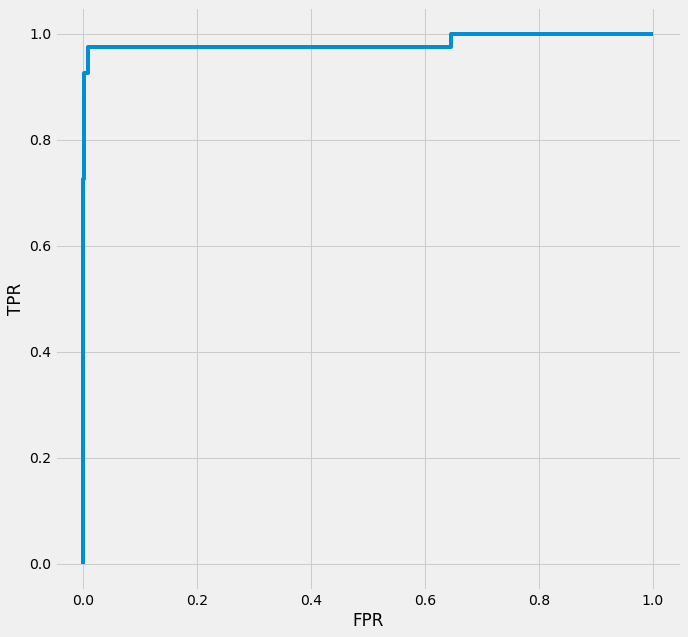

In [142]:
judge_model(log_tfidf, 'Logistic Regression TD-IDF', plot=True)

RANDOM FOREST TD-IDF
--------------------
Training Performance
-> Acc: 1.0
-> AUC: 1.0
Testing Performance
-> Acc: 1.0
-> AUC: 0.985554600171969



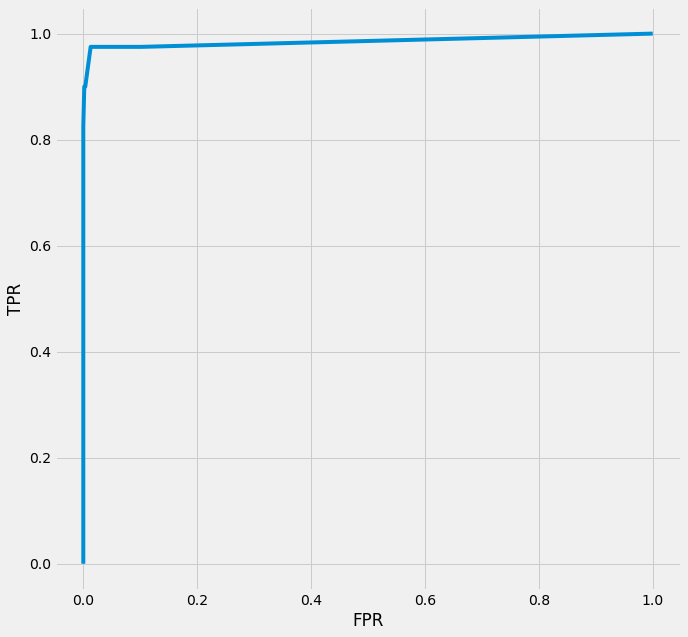

In [143]:
judge_model(forest_tfidf_ros, 'RANDOM FOREST TD-IDF', plot=True)

In [144]:
from __future__ import print_function

from sklearn import datasets
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=score)
    clf.fit(train_data_features_cv, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
  

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1



/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metric

Best parameters set found on development set:

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



In [145]:
from __future__ import print_function

from sklearn import datasets
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report


print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'C': [ 0.1, 1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5, scoring=score)
    clf.fit(train_data_features_tfidf,y_train)

    print("Best parameters set found on development set:")
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()


Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1



/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Def

Best parameters set found on development set:
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Grid scores on development set:



/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

In [146]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

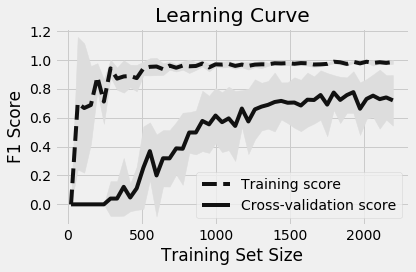

In [147]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), 
                                                        train_data_features_tfidf, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='f1',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metric

/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/melih/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


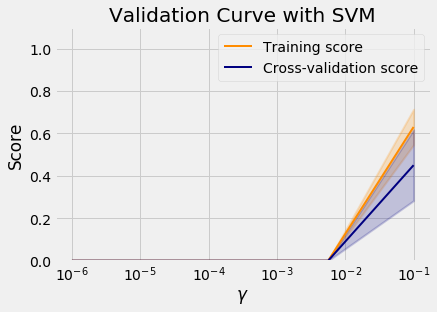

In [148]:
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve


param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), train_data_features_tfidf, y_train, param_name="gamma", param_range=param_range,
    cv=5, scoring="f1", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()